Packages

In [3]:
import pathlib
from pathlib import Path
import os 

import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import gsw
import cmocean as cmo
import scipy
from scipy import stats
import netCDF4
from netCDF4 import Dataset as nc
import cartopy.crs as ccrs
import matplotlib
import seaborn as sns

from AirSeaFluxCode import AirSeaFluxCode

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
import math

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


import scipy.io
import mat73
import glob 
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.ticker as mticker


font = {'weight' : 'normal',
        'size'  : 20}
matplotlib.rc('font', **font)

Functions

In [4]:
import math
def wind_sp_kt_to_ms(wind_kts):
    
    return wind_kts*0.514444  #kt to m/s

def wind_sp_to_10m(wind_sp, z0=1.52e-4, zm=3.4, z10=10):
    
    """Correct wind speed data from a given height to 10m above sea level.

       wind_sp = wind speed measurement (m/s)
       z0      = roughness length
       zm      = height of wind measurement
       z10     = height to correct to
    """
    
    return wind_sp*(math.log(z10/z0)/math.log(zm/z0))

def wind_direction(v, u):
    DIR=90-np.rad2deg(np.arctan(v / u) )
    return DIR

from tqdm import tqdm  # Assuming you're using the tqdm library for progress tracking

def colocate_era5_sd(sd, era5, var):
    """
    Colocates ERA5 data with Shipboard Data (SD) based on time, latitude, and longitude.

    Args:
    - sd (xarray.Dataset): Shipboard Data with time, longitude, and latitude dimensions.
    - era5 (xarray.Dataset): ERA5 data with time, longitude, and latitude dimensions.
    - var (str): The variable to be colocated.

    Returns:
    - era5_var (numpy.ndarray): An array of ERA5 variable values colocated with SD.
    """

    # Initialize an empty array to store ERA5 variable values
    era5_var = np.ndarray(sd.time.size)

    # Iterate through each time step in Shipboard Data (SD)
    for t in tqdm(range(sd.time.size)):

        # Find the matching time index in ERA5 data
        idx = sd.time[t] == era5.time

        # Find the latitude and longitude indices in ERA5 data that are closest to SD coordinates
        lon_idx = np.argmin(np.abs(sd.longitude.data[t] - era5.longitude.data))
        lat_idx = np.argmin(np.abs(sd.latitude.data[t] - era5.latitude.data))

        # Extract and store the ERA5 variable value for the matching time and location
        era5_var[t] = era5[var].isel(time=idx, latitude=lat_idx, longitude=lon_idx).data

    return era5_var

def era5dewtorh(era5_ds):
    # Extract dew point temperature (Dp) values from the input dataset
    Dp = era5_ds.d2m.values-273.15 # dew point temperature in celsius

    # Extract air temperature (T) values from the input dataset, and convert to celsius
    T = era5_ds.t2m.values # temperature in celsius
    
    # Calculate relative humidity (RH) using the formula and add it to the input dataset
    era5_ds['rh'] = (('time', 'latitude', 'longitude'),
                     100 * (np.exp((17.625 * Dp) / (243.04 + Dp)) / np.exp((17.625 * T) / (243.04 + T))))
    
    # Return the input dataset with the 'rh' variable added
    return era5_ds

def dist_era5_sd(sd, era5):
    """
    Colocates ERA5 data with Shipboard Data (SD) based on time, latitude, and longitude.

    Args:
    - sd (xarray.Dataset): Shipboard Data with time, longitude, and latitude dimensions.
    - era5 (xarray.Dataset): ERA5 data with time, longitude, and latitude dimensions.

    Returns:
    - dist (numpy.ndarray): An array of distance in meters between nearest ERA5 gridpoint and SD.
    """

    # Initialize an empty array to store ERA5 variable values
    dist = np.ndarray(sd.time.size)
    #time = np.ndarray(sd.time.size)
    # Iterate through each time step in Shipboard Data (SD)
    for t in tqdm(range(sd.time.size)):

        # Find the matching time index in ERA5 data
        idx = sd.time[t] == era5.time

        # Find the latitude and longitude indices in ERA5 data that are closest to SD coordinates
        lon_idx = np.argmin(np.abs(sd.longitude.data[t] - era5.longitude.data))
        lat_idx = np.argmin(np.abs(sd.latitude.data[t] - era5.latitude.data))

        # Extract and store the ERA5 variable value for the matching time and location
        dist[t] = gsw.distance([era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['longitude'].data, sd.longitude[t]],[era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['latitude'].data, sd.latitude[t]]) 
        
        #dist[t]= (((era5.latitude[lat_idx]-sd.latitude[lat_idx])**2)+((era5.longitude[lon_idx]-sd.longitude[lon_idx])**2))**0.5
        #time[t] = era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['time']
        
        
    return dist

def plot_eddies(eddies, ax):
    
    for eddy in range(np.shape(np.array(eddies['Anticyclonic_Cell'], dtype=object))[0]):
        
        eddy_out_lon = eddies['Anticyclonic_Cell'][eddy][4]
        eddy_out_lat = eddies['Anticyclonic_Cell'][eddy][5]

        ax.plot(eddy_out_lon, eddy_out_lat, transform=ccrs.PlateCarree(), c='r', lw=0.5, zorder=3)
       
    ax.plot(eddy_out_lon, eddy_out_lat, transform=ccrs.PlateCarree(), c='r', lw=0.5, zorder=3, label='Anticyclonic cell')
        
#         eddy_in_lon = eddies['Anticyclonic_Cell'][eddy][8]
#         eddy_in_lat = eddies['Anticyclonic_Cell'][eddy][9]
  
#         ax.plot(eddy_in_lon, eddy_in_lat, transform=ccrs.PlateCarree(), c='r', ls='--', lw=1)
        
    for eddy in range(np.shape(np.array(eddies['Cyclonic_Cell'], dtype=object))[0]):
        
        eddy_out_lon = eddies['Cyclonic_Cell'][eddy][4]
        eddy_out_lat = eddies['Cyclonic_Cell'][eddy][5]
    
        ax.plot(eddy_out_lon, eddy_out_lat, transform=ccrs.PlateCarree(), c='b', lw=0.5, zorder=3)
    ax.plot(eddy_out_lon, eddy_out_lat, transform=ccrs.PlateCarree(), c='b', lw=0.5, zorder=3, label='Cyclonic cell')   
    
#         eddy_in_lon = eddies['Cyclonic_Cell'][eddy][8]
#         eddy_in_lat = eddies['Cyclonic_Cell'][eddy][9]
  
#         ax.plot(eddy_in_lon, eddy_in_lat, transform=ccrs.PlateCarree(), c='b', ls='--', lw=1)


def gridlines(ax,lon_tick,lat_tick, ToF_bottom, ToF_left):
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      x_inline=False, y_inline=False,
                      linewidth=0.75, alpha=0.5, linestyle='--',color='w',
                      ylocs = mpl.ticker.MultipleLocator(base=lat_tick),xlocs = mpl.ticker.MultipleLocator(base=lon_tick))
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
#    gl.xlocator = mticker.FixedLocator([0, 10, 20, 30])
    
    gl.xpadding=10
    gl.ypadding=10
    gl.bottom_labels = ToF_bottom
    gl.left_labels = ToF_left

Load datasets

In [5]:
ds=xr.open_dataset( pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ds.nc')
ERA5=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/ERA5file.nc')
coloc3=pd.read_csv(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/coloc3.csv') #open coloc3
dsadcpH=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/dsadcpH.nc')
ostia=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/ostia.nc')
ERA5big=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5big.nc')
ostia_regrid=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ostia_regrid.nc')
coloc4=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/coloc4.csv')

ERA5_ostia_rec=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_ostia_sst_rec.csv').to_xarray() #reconstructed terms ERA5 w ostia sst
ERA5_bulk_rec=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_bulk_rec.csv').to_xarray() #reconstructed terms ERA5
ERA5_skin_rec=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_skin_rec.csv').to_xarray() #reconstructed terms ERA5
SD_rec=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/SD_rec.csv').to_xarray() #reconstructed terms SD

ERA5_ostia_ASFC=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_ostia_sst_ASFC.csv') #ASFC output ERA5 (coloc3) w ostia sst
ERA5_skin_ASFC=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_skin_ASFC.csv') #ASFC output ERA5 w skin sst(coloc3)
ERA5_bulk_ASFC=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_bulk_ASFC.csv') #ASFC output ERA5 w bulk sst(coloc3)

SD_ASFC=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/SD_ASFC.csv') #ASFC output SD #Updated to wl=0

SSH=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/SSH.nc')
dsD=ds.reset_coords().resample(time='1D').mean().set_coords(['latitude','longitude']) #resample to daily res. for mapping

rec_ds_ERA5=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleERA5.nc')
rec_r2=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleCORR_R2.nc')

SD_rec=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/SD_rec.csv') #Updated to wl=0

dsadcpH["dist_along_track"] = ("time"), np.insert(np.cumsum(gsw.distance(dsadcpH["longitude"],dsadcpH["latitude"])),0,0)
dsadcpH["dist_between_dp"] = ("time"), np.insert((gsw.distance(dsadcpH["longitude"],dsadcpH["latitude"])),0,0)
dist_along_track=dsadcpH.dist_along_track/1000

In [4]:
#print((dsadcpH["dist_between_dp"]/1000).mean())
#print((dsadcpH["dist_between_dp"]/1000).max())

## Overview map

In [23]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.ticker as mticker

def gridlines(ax,lon_tick,lat_tick, ToF_bottom, ToF_left):
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      x_inline=False, y_inline=False,
                      linewidth=0.75, alpha=0.2, linestyle='--',color='grey',
                      ylocs = mpl.ticker.MultipleLocator(base=lat_tick),xlocs = mpl.ticker.MultipleLocator(base=lon_tick))
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
#    gl.xlocator = mticker.FixedLocator([0, 10, 20, 30])
    
    gl.xpadding=10
    gl.ypadding=10
    gl.bottom_labels = ToF_bottom
    gl.left_labels = ToF_left


In [24]:
msk=np.isfinite(dsadcpH.sst)
dsadcpH=dsadcpH.isel(time=msk)
dsD=dsadcpH.reset_coords().resample(time='1D').mean().set_coords(['latitude','longitude']) #resample to daily res. for mapping

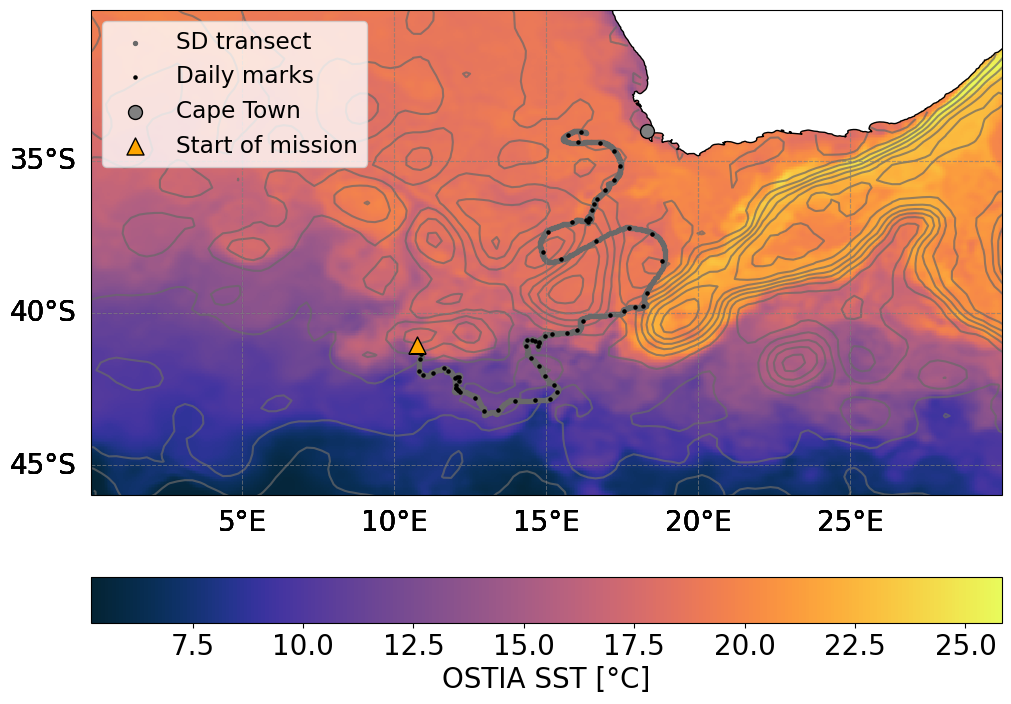

In [25]:
fig, ax=plt.subplots(figsize=[10,9],subplot_kw={'projection':ccrs.PlateCarree()}, constrained_layout=True)

cbar=ax.pcolormesh(ostia.longitude, ostia.latitude, ostia.sst.isel(time=1625)-273.15, cmap=cmo.cm.thermal)
plt.colorbar(cbar,ax=ax, label='OSTIA SST [°C]', orientation='horizontal')

ax.scatter(dsadcpH.longitude, dsadcpH.latitude, s=8, label='SD transect', c='dimgrey', zorder=2)#, alpha=0.2)
ax.scatter(dsD.longitude, dsD.latitude, c='k', s=5, label='Daily marks', zorder=5)
#ax.contour(SSH.longitude, SSH.latitude, SSH.isel(time=82).adt, colors='dimgray', zorder=1, levels=20, alpha=0.7)

ax.contour(SSH.longitude, SSH.latitude, SSH.isel(time=82).adt, colors='dimgray', zorder=1, levels=np.arange(-1.8, 2, 0.2), alpha=0.7)
#ax.contour(SSH.longitude, SSH.latitude, SSH.isel(time=82).adt, colors='maroon', zorder=1, levels=[0.6], alpha=0.7)

#plt.contour(gebco.lon, gebco.lat, gebco.elevation,levels=[0], colors='k')

ax.set_xlabel('Longitude [°E]')
ax.set_ylabel('Latitude [°N]')

ax.scatter(18.3, -34, c='grey', marker='o', s=100, edgecolor='k', label='Cape Town', zorder=4)

ax.scatter(dsadcpH.longitude.isel(time=0), dsadcpH.latitude.isel(time=0), c='orange', marker='^', s=150, edgecolor='k', label='Start of mission', zorder=6)
#plt.scatter(ds.longitude.sel(time=ds.time.max()), ds.latitude.sel(time=ds.time.max()), c='r', marker='*', s=300, edgecolor='k')#, label='End of mission')

ax.set_xlim(ostia.longitude.min(), ostia.longitude.max())
ax.set_ylim(ostia.latitude.min(), ostia.latitude.max())
ax.legend(fontsize='small', loc='upper left')

#ax.set_title('Cape Basin and the Agulhas region 2022-11-22')

ax.grid(alpha=0.3)

for k,spine in ax.spines.items():  #ax.spines is a dictionary
            spine.set_zorder(12)
            gridlines(ax,5,5, True, True)


ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)

plt.savefig(pathlib.Path('.').absolute().parent/'MTmichaela/final_figs/area.png')

## SD-ERA5 corr

In [6]:
#coloc3msk
variables=['P_SEA', 'WIND_CORR10', 'u10', 'v10','dwlw', 'dwsw', 'sst', 't2m' , 'rh', 'skt']
coloc3msk=[] 
for i in np.arange(len(variables)):
    msk=np.isfinite(dsadcpH[variables[i]])
    coloc3msk.append(colocate_era5_sd(dsadcpH.sel(time=msk), ERA5big , variables[i]))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1638/1638 [00:02<00:00, 784.30it/s]


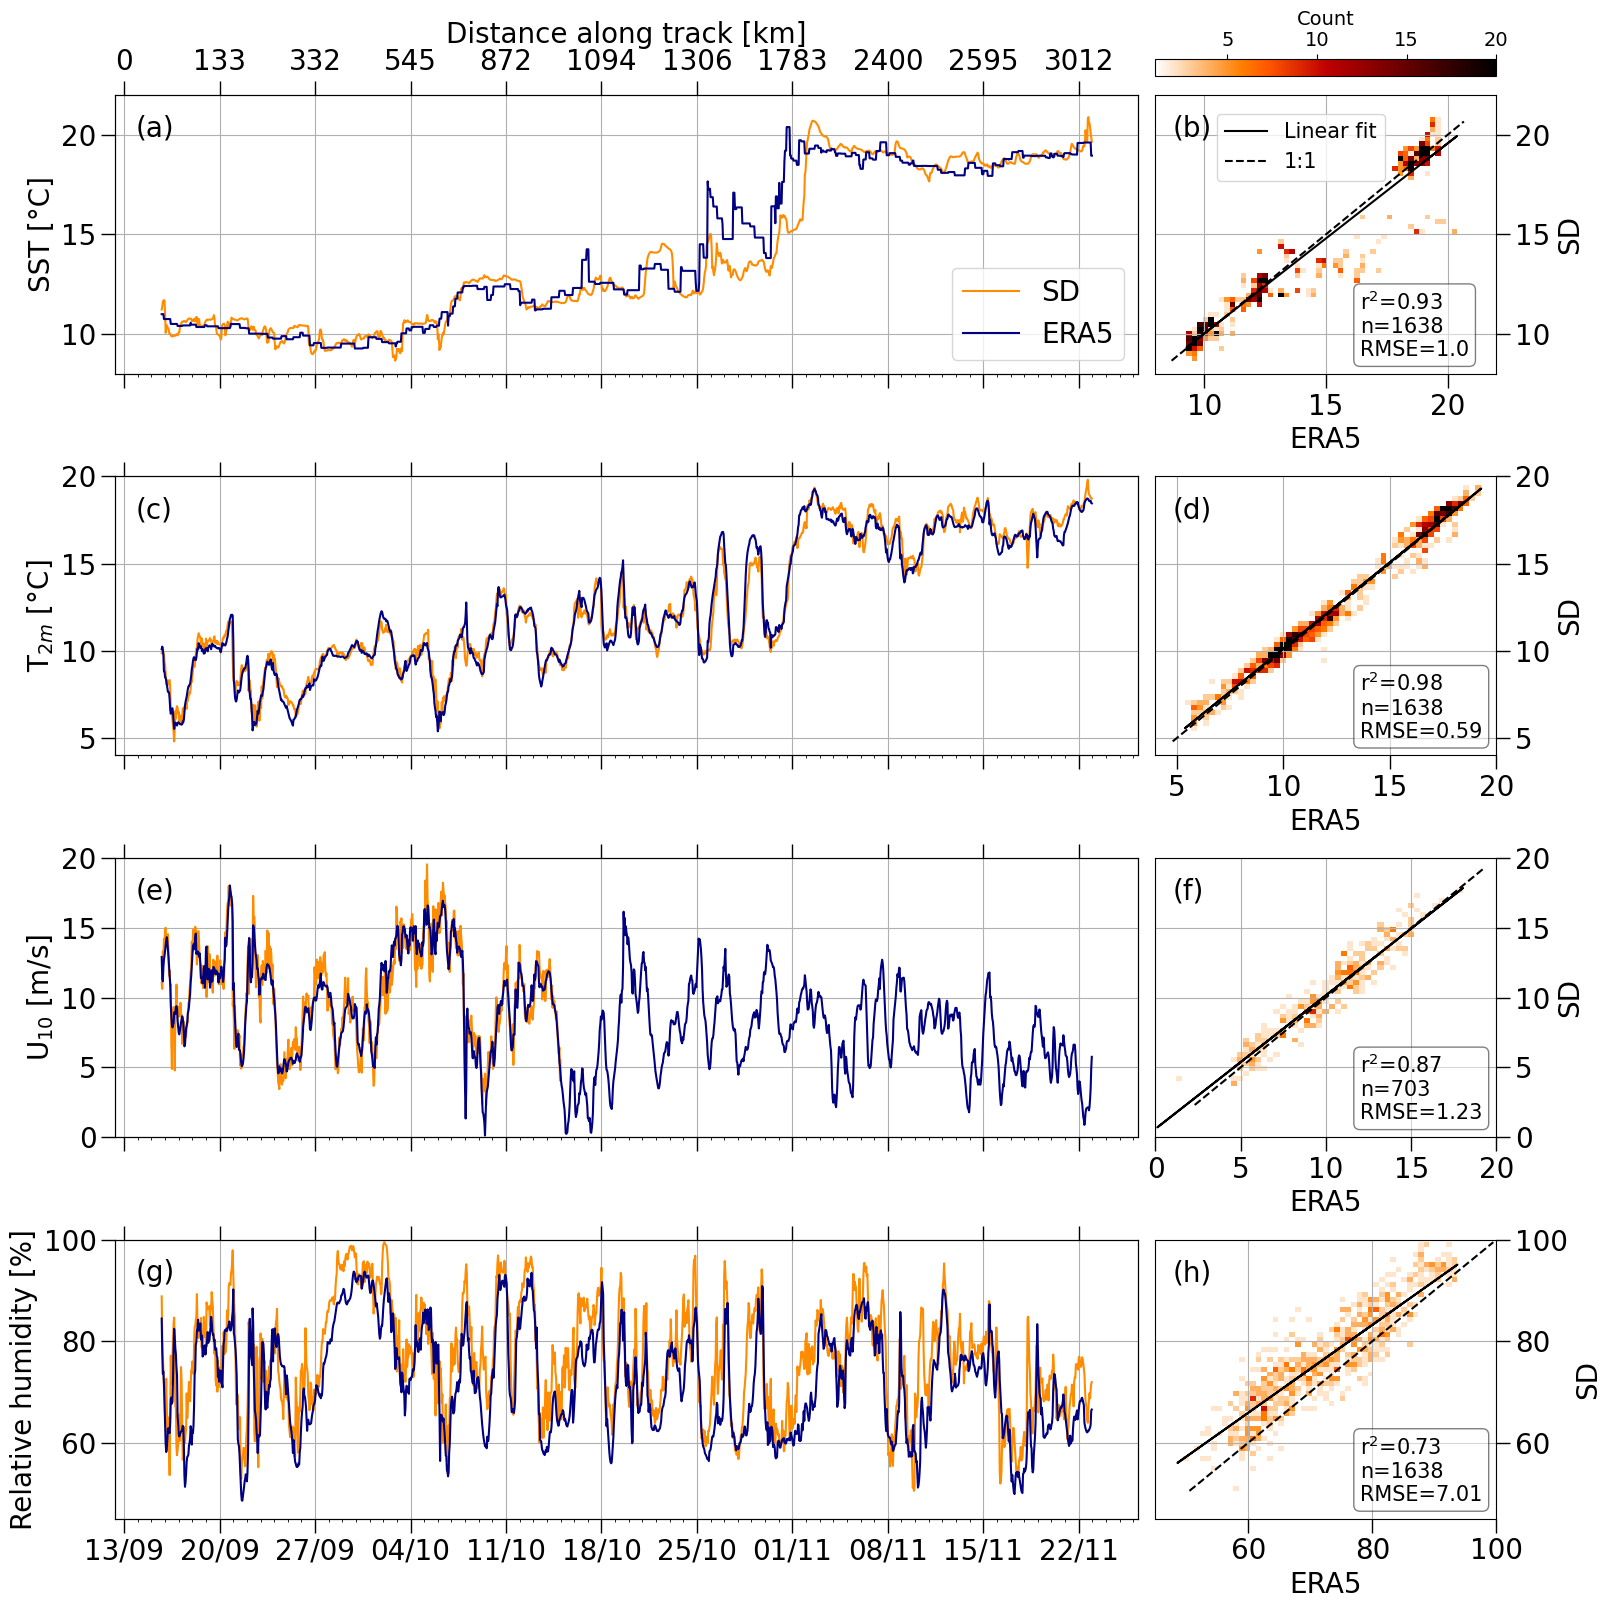

In [7]:
dist_along_track=dsadcpH.dist_along_track/1000
fig, ax = plt.subplot_mosaic([['a','a','a' ,'b'], ['c','c','c', 'd'], ['e','e','e' ,'f'], ['g','g','g', 'h']], figsize=[16,16], layout='constrained')
tims=['a','c','e', 'g']
corr=['b', 'd', 'f', 'h']
var=['sst', 't2m', 'WIND_CORR10', 'rh']
colocno=[6, 7, 1, 8] #sst, t2m, wind_corr10, rh
textstr=[]
lin=[]

ticksize=14

vmin=1
vmax=20

for i in np.arange(len(var)):
    ax[tims[i]].plot(dsadcpH.time, dsadcpH[var[i]], label='SD', color='darkorange')
    ax[tims[i]].plot(dsadcpH.time, coloc3[var[i]], label='ERA5', color='navy')
    
    scat=ax[corr[i]].hist2d(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]])), bins=50,cmin=1, cmax=60,vmin=vmin, vmax=vmax, cmap='gist_heat_r')
    
    #Create linear fit line and plot
    y=dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))
    x=coloc3msk[colocno[i]]
 
    #obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(x, y, 1)

    #add linear regression line to scatterplot 
    ax[corr[i]].plot(x, m*x+b, color='k', label='Linear fit')
    
    #Create stats and statbox
    y_actual = coloc3msk[colocno[i]] 
    y_predicted =dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))
    RMSE = math.sqrt(mean_squared_error(y_actual, y_predicted))
    
    
    r2=scipy.stats.linregress(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))).rvalue**2
    n = len(coloc3msk[colocno[i]])
    #p= scipy.stats.linregress(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))).pvalue
    
    textstr.append( 'r$^2$='+ str(round(r2, 2)) + '\n'+ 'n=' +str(n) + '\n' + 'RMSE='+ str(round(RMSE,2)) )
                              
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#    ax[corr[i]].set_aspect('equal', adjustable="datalim")
    
    # place a text box in upper left in axes coords
    ax[corr[i]].annotate(textstr[i], xy=(0.6, 0.3), xycoords='axes fraction', bbox=props, va='top',fontsize=15)
    
    
    ax[corr[i]].set_xlabel('ERA5')
    ax[corr[i]].set_ylabel('SD')
    
      #ad grid, legend, 1:1 line
    #loc='upper left')
    ax[tims[i]].xaxis.set_minor_locator(mdates.DayLocator())
    ax[tims[i]].grid()
    ax[corr[i]].grid()
    ax[corr[i]].plot(np.arange(dsadcpH[var[i]].min(), dsadcpH[var[i]].max(), 1), np.arange(dsadcpH[var[i]].min(), dsadcpH[var[i]].max(), 1) , linestyle='--', color='k', label=('1:1'))
    ax[corr[i]].yaxis.tick_right()
    ax[corr[i]].yaxis.set_label_position("right")
    
ax['a'].set_ylabel('SST [°C]')   
ax['c'].set_ylabel('T$_{2m}$ [°C]')   
ax['e'].set_ylabel('U$_{10}$ [m/s]')      
ax['g'].set_ylabel('Relative humidity [%]') 

ax['a'].legend(loc='lower right')

    #coloc3: PSEA, WIND_CORR10, u10, v10, dwlw, dwsw, sst, t2m, rh
       
[ax[i].tick_params(labelbottom=False) for i in "ace"]    

ax['a'].set_ylim(8,22)
ax['b'].set_xlim(8,22)

ax['c'].set_ylim(4,20)
ax['d'].set_xlim(4,20)

ax['e'].set_ylim(0,20)
ax['f'].set_xlim(0,20)

ax['g'].set_ylim(45,100)
ax['h'].set_xlim(45,100)

ax['b'].sharey(ax['a'])
ax['d'].sharey(ax['c'])
ax['f'].sharey(ax['e'])
ax['h'].sharey(ax['g'])

#bdfh

#ax['b'].set_xlim(10,20)
#ax['b'].set_ylim(10,20)

#ax['d'].set_xlim(5.5,19)
#ax['d'].set_ylim(5.5,19)

#ax['f'].set_xlim(3,17)
#ax['f'].set_ylim(3,17)

#ax['h'].set_xlim(50,96)
#ax['h'].set_ylim(50,96)

x=0.02
y=0.85

ax['a'].annotate('(a)', xy=(x,y), xycoords='axes fraction') #, bbox=bbox)
ax['c'].annotate('(c)', xy=(x,y), xycoords='axes fraction') #, bbox=bbox)
ax['e'].annotate('(e)', xy=(x,y), xycoords='axes fraction') #, bbox=bbox)
ax['g'].annotate('(g)', xy=(x,y), xycoords='axes fraction') #, bbox=bbox)



x=0.05
y=0.85
ax['b'].annotate('(b)', xy=(x,y), xycoords='axes fraction') #, bbox=bbox)
ax['d'].annotate('(d)', xy=(x,y), xycoords='axes fraction') #, bbox=bbox)
ax['f'].annotate('(f)', xy=(x,y), xycoords='axes fraction') #, bbox=bbox)
ax['h'].annotate('(h)', xy=(x,y), xycoords='axes fraction') #, bbox=bbox)

#cax = ax['b'].inset_axes([0.32, 0.9, 0.25, 0.05])
cbar=fig.colorbar(scat[3], ax=ax['b'], label=('Count'), orientation='horizontal', location='top', pad=-0.2)
cbar.ax.tick_params(labelsize=ticksize)
cbar.set_label(label='Count', size=ticksize)

ax['b'].legend(loc='upper left', bbox_to_anchor=(0.15, 0.97), fontsize=15 )


ax['a'].xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax['e'].xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
myFmt = mdates.DateFormatter('%d'+'/'+'%m')
ax['a'].xaxis.set_major_formatter(myFmt)
#ax['a'].tick_params(axis='x', labelrotation=40)


#############SPATIAL AXIS######################

ax2=ax['a'].twiny()
ax2.plot(dsadcpH.time, dsadcpH['sst'], label='SD', color='darkorange', alpha=0)
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
xticks_timeunits = ax2.get_xticks()

#xticks_timeunits = np.linspace(mdates.date2num(np.min(dsadcpH.time.values)) , mdates.date2num(np.max(dsadcpH.time.values)) , 10)

def lookup_table(ticktime):
    index_of_nearest_time = np.argmin(np.abs(mdates.date2num(dsadcpH.time)-ticktime))
    return dist_along_track[index_of_nearest_time]
    
xticks_distanceunits = xticks_timeunits * np.NaN 
for idx, val in enumerate(xticks_timeunits):
    xticks_distanceunits[idx] = int(lookup_table(xticks_timeunits[idx]))
    
ticks=[]
for i in np.arange(len(xticks_timeunits)):
    ticks.append(int(xticks_distanceunits[i]))

xticks_distanceunits=np.array(ticks)


ax2.set_xticks(xticks_timeunits)
ax2.set_xticklabels(xticks_distanceunits)

ax3=ax['c'].twiny()
ax4=ax['e'].twiny()
ax5=ax['g'].twiny()

ax3.plot(dsadcpH.time, dsadcpH['t2m'], label='SD', color='darkorange', alpha=0)
ax4.plot(dsadcpH.time, coloc3['WIND_CORR10'], label='SD', color='darkorange', alpha=0)
ax5.plot(dsadcpH.time, dsadcpH['rh'], label='SD', color='darkorange', alpha=0)

ax3.set_xticks(xticks_timeunits)
ax4.set_xticks(xticks_timeunits)
ax5.set_xticks(xticks_timeunits)

ax3.set_xticklabels(xticks_distanceunits)
ax4.set_xticklabels(xticks_distanceunits)
ax5.set_xticklabels(xticks_distanceunits)

ax3.set_xticklabels(['']*11)
ax4.set_xticklabels(['']*11)
ax5.set_xticklabels(['']*11)

[ax[i].tick_params(axis='both', which='major', width=1, length=10) for i in 'abcdefgh']
ax2.tick_params(axis='both', which='major', width=1, length=10)
ax3.tick_params(axis='both', which='major', width=1, length=10)
ax4.tick_params(axis='both', which='major', width=1, length=10)
ax5.tick_params(axis='both', which='major', width=1, length=10)

[ax[i].sharex(ax['a']) for i in 'ceg'] 

#ax['g'].tick_params(axis='x', which='major', labelsize=22)
ax2.set_xlabel('Distance along track [km]')
    
plt.savefig(pathlib.Path('.').absolute().parent/'MTmichaela/final_figs/SD-ERA5-params.png')

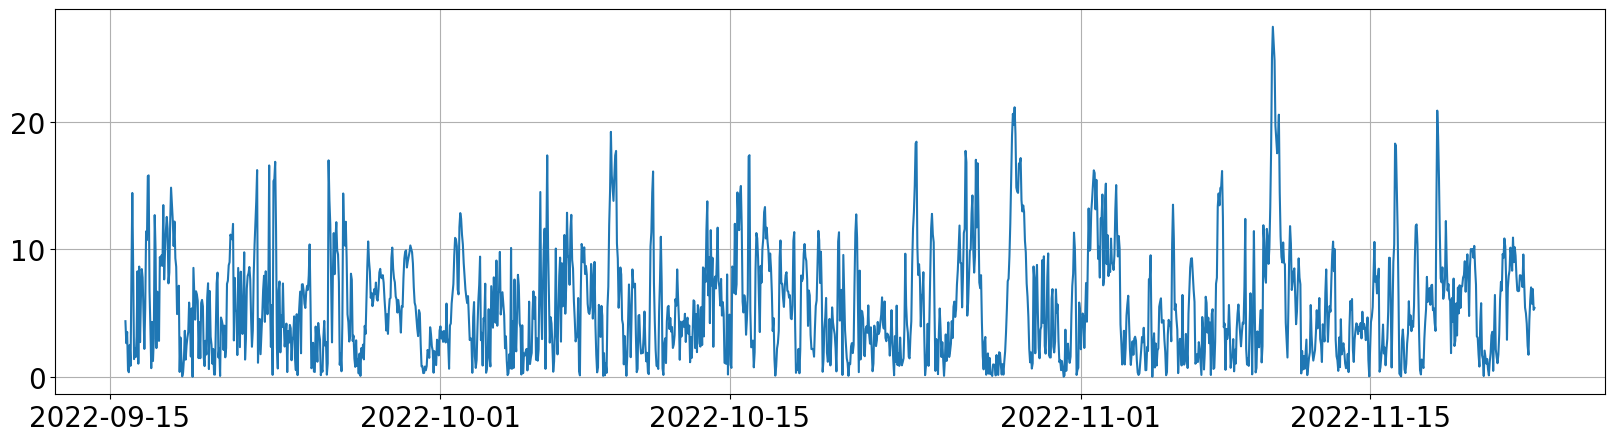

In [8]:
fig,ax=plt.subplots(figsize=[20,5])

ax.plot(dsadcpH.time, np.abs(coloc3.rh-dsadcpH.rh))
ax.grid()

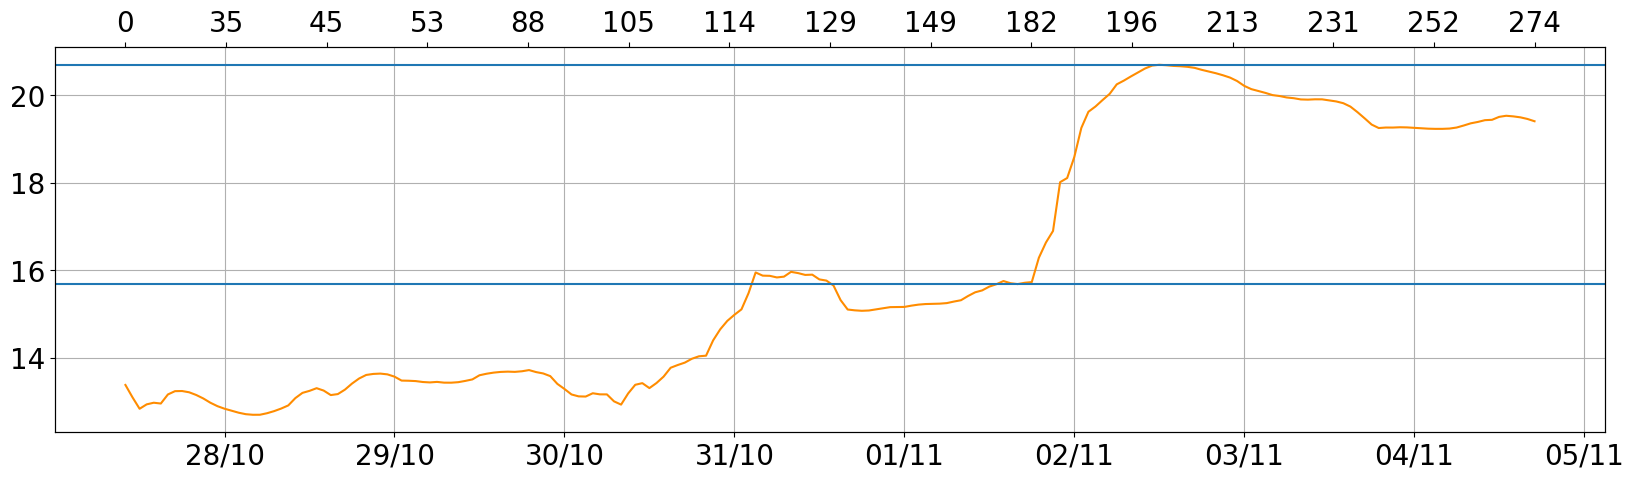

In [19]:
fig,ax=plt.subplots(figsize=[20,5])

i=1000 # choose index for start time on zoom-window
diff=200
sub=dsadcpH.sel(time=dsadcpH.time[i:i+diff])

plt.plot(sub.time, sub.sst, c='darkorange', label='SD 1067')


ax2=plt.twiny()
ax2.plot(sub.time, sub['sst'], label='SD 1067', color='darkorange', alpha=0)
#ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
#xticks_timeunits = ax2.get_xticks()

xticks_timeunits = np.linspace(mdates.date2num(np.min(sub.time.values)) , mdates.date2num(np.max(sub.time.values)) , 15)

def lookup_table(ticktime):
    index_of_nearest_time = np.argmin(np.abs(mdates.date2num(sub.time)-ticktime))
    return dist_along_track[index_of_nearest_time]
    
xticks_distanceunits = xticks_timeunits * np.NaN 
for idx, val in enumerate(xticks_timeunits):
    xticks_distanceunits[idx] = int(lookup_table(xticks_timeunits[idx]))
    
ticks=[]
for i in np.arange(len(xticks_timeunits)):
    ticks.append(int(xticks_distanceunits[i]))

xticks_distanceunits=np.array(ticks)


ax2.set_xticks(xticks_timeunits)
ax2.set_xticklabels(xticks_distanceunits)

myFmt = mdates.DateFormatter('%d'+'/'+'%m')
ax.xaxis.set_major_formatter(myFmt)
ax.axhline(15.7)
ax.axhline(20.7)

ax.grid()

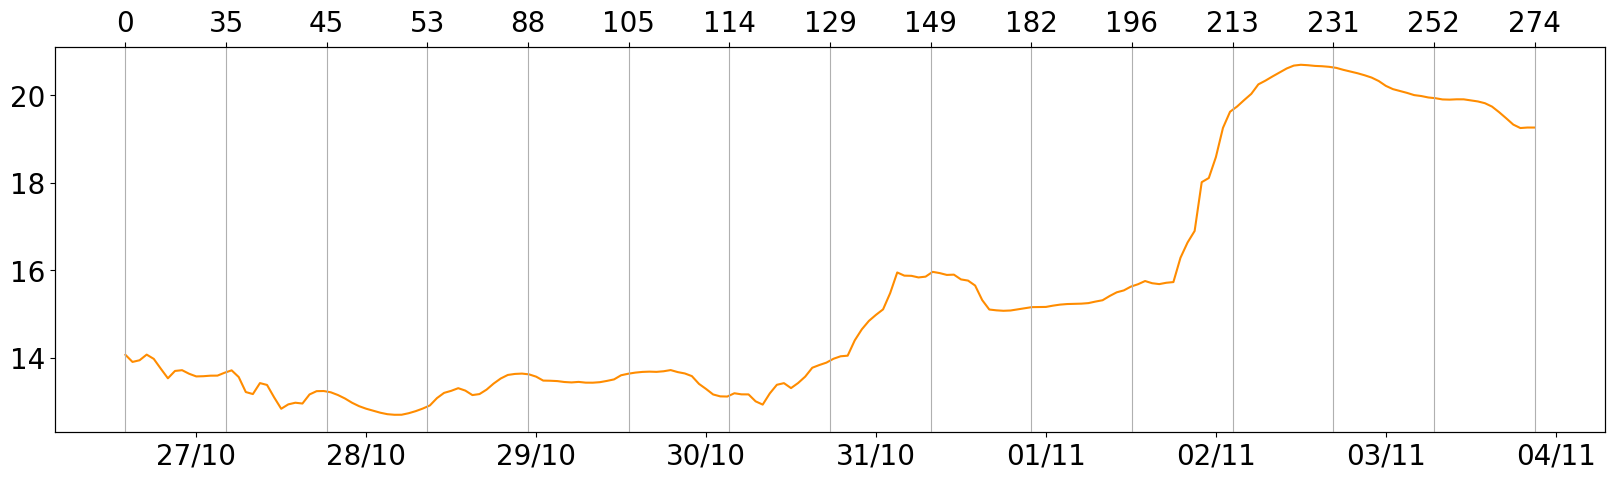

In [20]:
fig,ax=plt.subplots(figsize=[20,5])

i=980 # choose index for start time on zoom-window
diff=200
sub=dsadcpH.sel(time=dsadcpH.time[i:i+diff])

plt.plot(sub.time, sub.sst, c='darkorange', label='SD 1067')


ax2=plt.twiny()
ax2.plot(sub.time, sub['sst'], label='SD 1067', color='darkorange', alpha=0)
#ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
#xticks_timeunits = ax2.get_xticks()

xticks_timeunits = np.linspace(mdates.date2num(np.min(sub.time.values)) , mdates.date2num(np.max(sub.time.values)) , 15)

def lookup_table(ticktime):
    index_of_nearest_time = np.argmin(np.abs(mdates.date2num(sub.time)-ticktime))
    return dist_along_track[index_of_nearest_time]
    
xticks_distanceunits = xticks_timeunits * np.NaN 
for idx, val in enumerate(xticks_timeunits):
    xticks_distanceunits[idx] = int(lookup_table(xticks_timeunits[idx]))
    
ticks=[]
for i in np.arange(len(xticks_timeunits)):
    ticks.append(int(xticks_distanceunits[i]))

xticks_distanceunits=np.array(ticks)


ax2.set_xticks(xticks_timeunits)
ax2.set_xticklabels(xticks_distanceunits)

myFmt = mdates.DateFormatter('%d'+'/'+'%m')
ax.xaxis.set_major_formatter(myFmt)

plt.grid()

## OSTIA

In [21]:
colocOSTIA=colocate_era5_sd(dsadcpH, ostia, 'sst')-273.15
colocOSTIA_regrid=colocate_era5_sd(dsadcpH, ostia_regrid, 'sst')-273.15

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1638/1638 [00:02<00:00, 795.56it/s]


NameError: name 'axb' is not defined

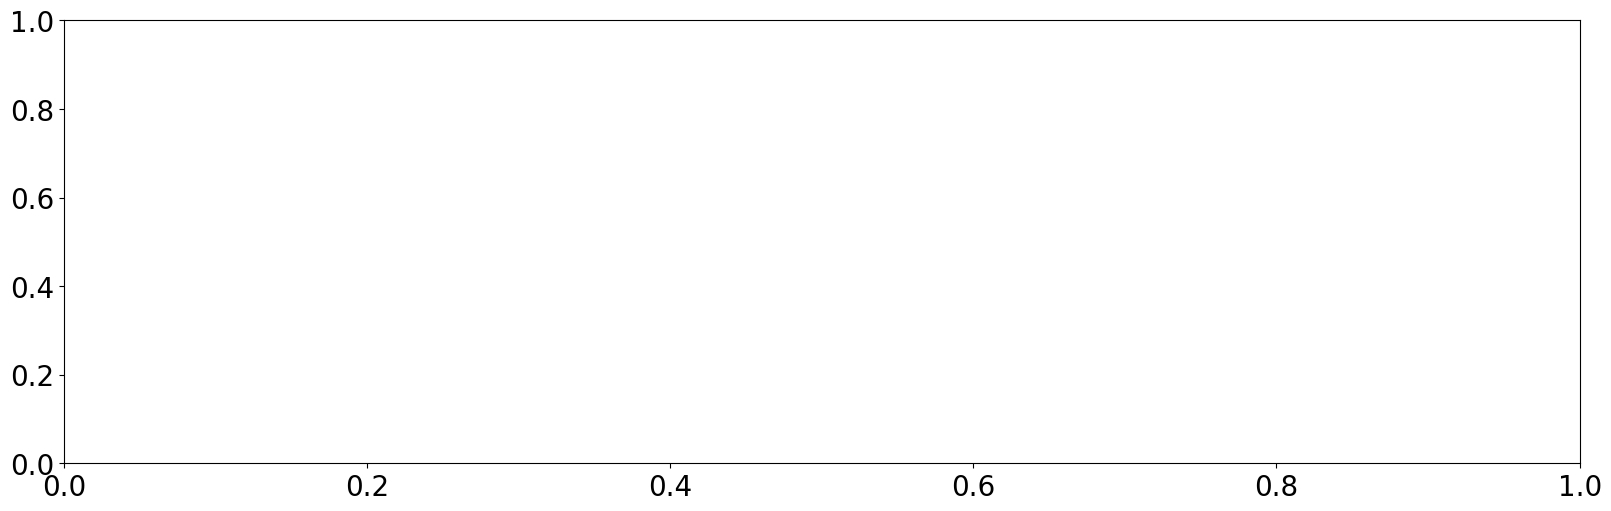

In [22]:
fig, ax = plt.subplot_mosaic([['b','b','b'], ['b','b','b'], ['b','b','b']], figsize=[16,5], layout='constrained')#, sharex=True)




axb.plot(dsadcpH.time, dsadcpH.sst, c='darkorange', label='SD1067')
axb.plot(dsadcpH.time, coloc3.sst, c='blue', label='ERA5')
axb.plot(dsadcpH.time, colocOSTIA_regrid, c='k', label='OSTIA 0.25°', linestyle='--')
axb.plot(dsadcpH.time, colocOSTIA, c='k', label='OSTIA 0.05°')


#bbox = dict(boxstyle="square", facecolor='w')#, fc="0.8", facecolor='w')


#ax['a'].annotate('B', xy=(0.02, 0.74), xycoords='axes fraction', bbox=bbox)
#axb.annotate('A', xy=(0.142, 0.88), xycoords='axes fraction', bbox=bbox)
#axb.set_facecolor('#D3D3D3')
#ax.grid()
axb.legend(fontsize='small')
axb.set_ylim(5,25)

#axb.set_xlabel('Date')
axb.set_ylabel('SST [°C]')

#sst difference axis
ax1=axb.twinx()
ax1.bar(dsadcpH.time, np.abs(dsadcpH.sst-coloc3.sst),alpha=1,width=pd.Timedelta(hours=1), label='|SD1067-ERA5|', color='navy')
ax1.bar(dsadcpH.time, np.abs(dsadcpH.sst-colocOSTIA_regrid),alpha=0.6,width=pd.Timedelta(hours=1), label='|SD1067-OSTIA 0.25°|', color='green')
ax1.bar(dsadcpH.time, np.abs(dsadcpH.sst-colocOSTIA),alpha=0.5,width=pd.Timedelta(hours=1), label='|SD1067-OSTIA 0.05°|', color='darkorange')

ax1.set_ylabel('SST difference [°C]')

ax1.legend(loc='center right', bbox_to_anchor=(1.0, 0.25), fontsize='small')
ax1.set_ylim(0,13)
ax1.yaxis.set_ticks(ticks=np.arange(0, 13, 3), labels=[0,3,6,9,12])

i=830 # choose index for start time on zoom-window

#Zoom window
x1, x2, y1, y2 = dsadcpH.time[i], dsadcpH.time[i+120], 11, 15 # subregion of the original image

# Make the zoom-in plot:
#axins = zoomed_inset_axes(axb, 2, loc='upper center')#, axes_kwargs=dict(anchor=[dsadcpH.time[50].values, 15]))#, loc='upper left') # zoom = 2

x_pos=0.25
y_pos=0.5

width=0.18
height=0.47

axins= axb.inset_axes([x_pos, y_pos, width, height], xticklabels=[], yticklabels=[]) 

axins.plot(dsadcpH.time, dsadcpH.sst, c='darkorange', label='SD 1067')
axins.plot(dsadcpH.time, coloc3.sst, c='blue', label='ERA5')
axins.plot(dsadcpH.time, colocOSTIA, c='k', label='OSTIA 0.05°')
axins.plot(dsadcpH.time, colocOSTIA_regrid, c='k', label='OSTIA 0.25°', linestyle='--')

axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.xticks(visible=False)
#axins.yticks(visible=False)
mark_inset(axb, axins, loc1=3, loc2=1, fc="none", ec="0.3", zorder=2)

axb.grid(which='major', zorder=1)

axb.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
myFmt = mdates.DateFormatter('%d'+'/'+'%m')
axb.xaxis.set_major_formatter(myFmt)
axb.xaxis.set_minor_locator(mdates.DayLocator())


ax2=axb.twiny()
ax2.plot(dsadcpH.time, dsadcpH['sst'], label='SD 1067', color='darkorange', alpha=0)
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
xticks_timeunits = ax2.get_xticks()

#xticks_timeunits = np.linspace(mdates.date2num(np.min(dsadcpH.time.values)) , mdates.date2num(np.max(dsadcpH.time.values)) , 10)

def lookup_table(ticktime):
    index_of_nearest_time = np.argmin(np.abs(mdates.date2num(dsadcpH.time)-ticktime))
    return dist_along_track[index_of_nearest_time]
    
xticks_distanceunits = xticks_timeunits * np.NaN 
for idx, val in enumerate(xticks_timeunits):
    xticks_distanceunits[idx] = int(lookup_table(xticks_timeunits[idx]))
    
ticks=[]
for i in np.arange(len(xticks_timeunits)):
    ticks.append(int(xticks_distanceunits[i]))

xticks_distanceunits=np.array(ticks)

ax2.set_xticks(xticks_timeunits)
ax2.set_xticklabels(xticks_distanceunits)

axb.tick_params(axis='both', which='major', width=1, length=10)
ax2.tick_params(axis='both', which='major', width=1, length=10)
ax1.tick_params(axis='both', which='major', width=1, length=10)


ax2.set_xlabel('Distance along track [km]')

plt.savefig(pathlib.Path('.').absolute().parent/'MTmichaela/final_figs/sst.png')

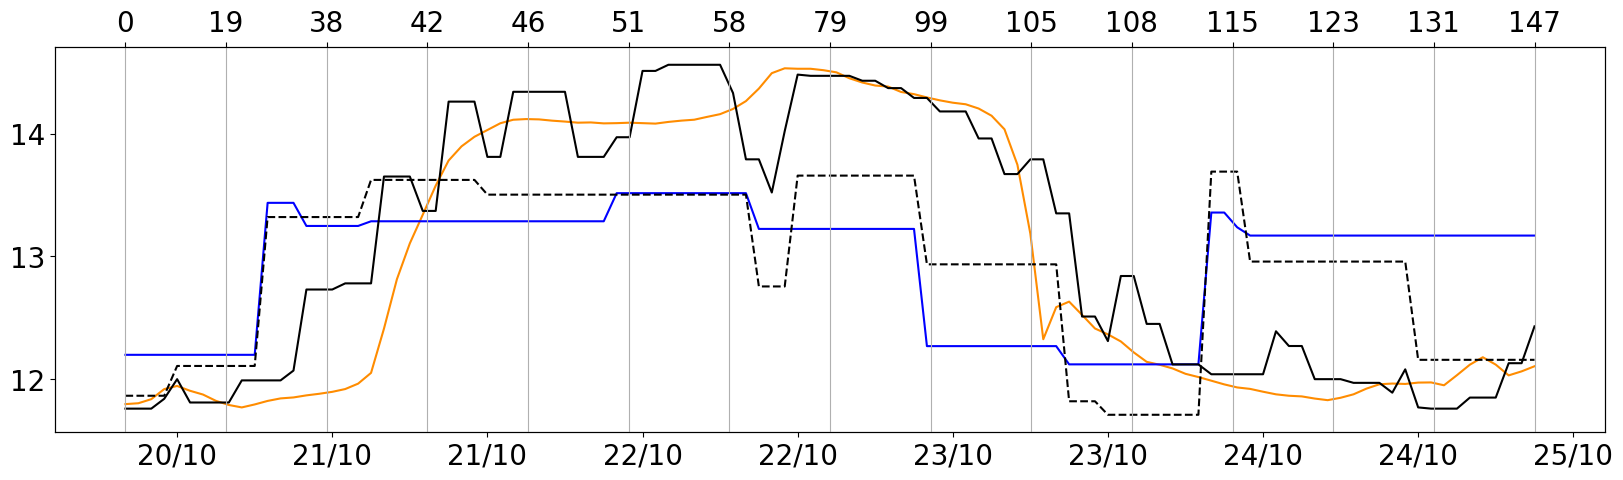

In [38]:
i=830 # choose index for start time on zoom-window
diff=110
sub=dsadcpH.sel(time=dsadcpH.time[i:i+diff])

fig, ax= plt.subplots(figsize=[20,5])

plt.plot(sub.time, sub.sst, c='darkorange', label='SD 1067')
plt.plot(sub.time, coloc3[i: i+diff].sst, c='blue', label='ERA5')
plt.plot(sub.time, colocOSTIA[i: i+diff], c='k', label='OSTIA 0.05°')
plt.plot(sub.time, colocOSTIA_regrid[i: i+diff], c='k', label='OSTIA 0.25°', linestyle='--')


ax2=plt.twiny()
ax2.plot(sub.time, sub['sst'], label='SD 1067', color='darkorange', alpha=0)
#ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
#xticks_timeunits = ax2.get_xticks()

xticks_timeunits = np.linspace(mdates.date2num(np.min(sub.time.values)) , mdates.date2num(np.max(sub.time.values)) , 15)

def lookup_table(ticktime):
    index_of_nearest_time = np.argmin(np.abs(mdates.date2num(sub.time)-ticktime))
    return dist_along_track[index_of_nearest_time]
    
xticks_distanceunits = xticks_timeunits * np.NaN 
for idx, val in enumerate(xticks_timeunits):
    xticks_distanceunits[idx] = int(lookup_table(xticks_timeunits[idx]))
    
ticks=[]
for i in np.arange(len(xticks_timeunits)):
    ticks.append(int(xticks_distanceunits[i]))

xticks_distanceunits=np.array(ticks)


ax2.set_xticks(xticks_timeunits)
ax2.set_xticklabels(xticks_distanceunits)

myFmt = mdates.DateFormatter('%d'+'/'+'%m')
ax.xaxis.set_major_formatter(myFmt)
ax2.grid()

#plt.legend()

In [25]:
print(np.abs(sub.sst-coloc3[i: i+diff].sst).values.mean())
print(np.abs(sub.sst-colocOSTIA[i: i+diff]).values.mean())
print(np.abs(sub.sst-colocOSTIA_regrid[i: i+diff]).values.mean())

2.5555261763025396
2.547974185446692
2.5223145896104


0.9165193906939408
0.28558376975238886
0.7494336589854628


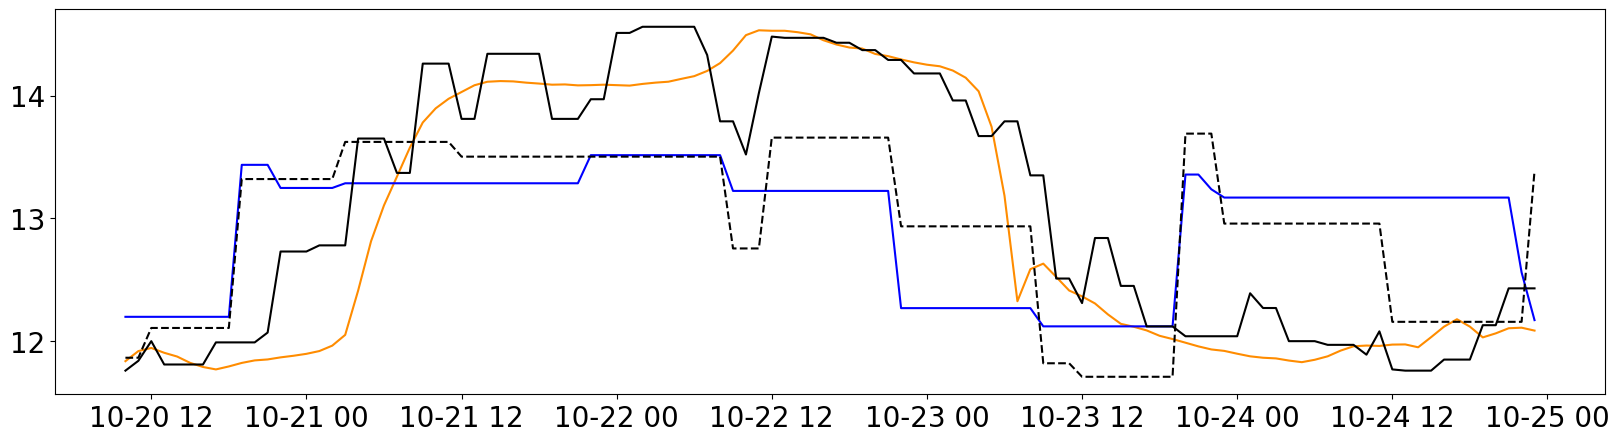

In [46]:
i=832 # choose index for start time on zoom-window
diff=110
sub=dsadcpH.sel(time=dsadcpH.time[i:i+diff])
fig, ax= plt.subplots(figsize=[20,5])

plt.plot(sub.time, sub.sst, c='darkorange', label='SD 1067')
plt.plot(sub.time, coloc3[i: i+diff].sst, c='blue', label='ERA5')
plt.plot(sub.time, colocOSTIA[i: i+diff], c='k', label='OSTIA 0.05°')
plt.plot(sub.time, colocOSTIA_regrid[i: i+diff], c='k', label='OSTIA 0.25°', linestyle='--')

#coloc3[i: i+diff].sst
#colocOSTIA[i: i+diff]
#colocOSTIA_regrid[i: i+diff]
print(np.abs(sub.sst-coloc3[i: i+diff].sst).values.mean())
print(np.abs(sub.sst-colocOSTIA[i: i+diff]).values.mean())
print(np.abs(sub.sst-colocOSTIA_regrid[i: i+diff]).values.mean())

In [35]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.ticker as mticker

def gridlines(ax,lon_tick,lat_tick, ToF_bottom, ToF_left):
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      x_inline=False, y_inline=False,
                      linewidth=0.75, alpha=0.2, linestyle='--',color='grey',
                      ylocs = mpl.ticker.MultipleLocator(base=lat_tick),xlocs = mpl.ticker.MultipleLocator(base=lon_tick))
    gl.top_labels = False
    gl.right_labels = True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
#    gl.xlocator = mticker.FixedLocator([0, 10, 20, 30])
    
    gl.xpadding=10
    gl.ypadding=10
    gl.bottom_labels = ToF_bottom
    gl.left_labels = ToF_left


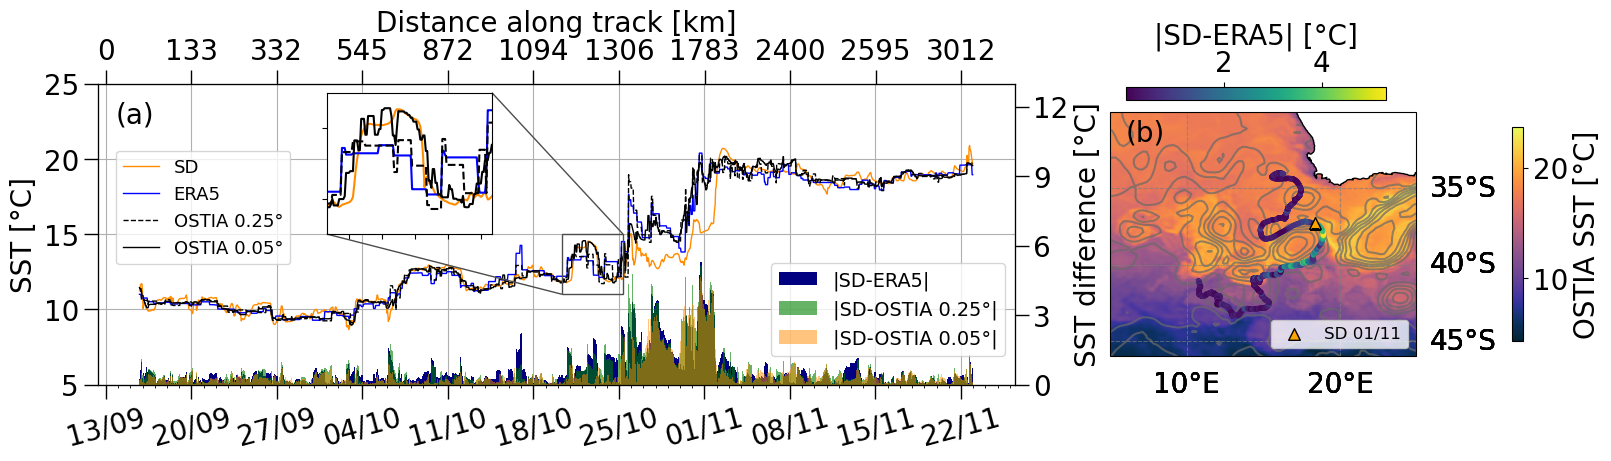

In [36]:
from matplotlib.gridspec import GridSpec
import gsw


fig = plt.figure(figsize=[16,4.5], layout="constrained")
gs = GridSpec(1, 4, figure=fig)

#####################SST & SAL####################################
axb = fig.add_subplot(gs[0, 0:3])

linewidth=1

axb.plot(dsadcpH.time, dsadcpH.sst, c='darkorange', label='SD', linewidth=linewidth)
axb.plot(dsadcpH.time, coloc3.sst, c='blue', label='ERA5', linewidth=linewidth)
axb.plot(dsadcpH.time, colocOSTIA_regrid, c='k', label='OSTIA 0.25°', linestyle='--', linewidth=linewidth)
axb.plot(dsadcpH.time, colocOSTIA, c='k', label='OSTIA 0.05°', linewidth=linewidth)


#bbox = dict(boxstyle="square", facecolor='w')#, fc="0.8", facecolor='w')


#ax['a'].annotate('B', xy=(0.02, 0.74), xycoords='axes fraction', bbox=bbox)
#axb.annotate('A', xy=(0.142, 0.88), xycoords='axes fraction', bbox=bbox)
#axb.set_facecolor('#D3D3D3')
#ax.grid()
#axb.legend(fontsize='small')
axb.set_ylim(5,25)

#axb.set_xlabel('Date')
axb.set_ylabel('SST [°C]')

#sst difference axis
ax1=axb.twinx()
ax1.bar(dsadcpH.time, np.abs(dsadcpH.sst-coloc3.sst),alpha=1,width=pd.Timedelta(hours=1), label='|SD-ERA5|', color='navy')
ax1.bar(dsadcpH.time, np.abs(dsadcpH.sst-colocOSTIA_regrid),alpha=0.6,width=pd.Timedelta(hours=1), label='|SD-OSTIA 0.25°|', color='green')
ax1.bar(dsadcpH.time, np.abs(dsadcpH.sst-colocOSTIA),alpha=0.5,width=pd.Timedelta(hours=1), label='|SD-OSTIA 0.05°|', color='darkorange')

ax1.set_ylabel('SST difference [°C]')

ax1.legend(loc='center right', bbox_to_anchor=(1.0, 0.25), fontsize='x-small')
ax1.set_ylim(0,13)
ax1.yaxis.set_ticks(ticks=np.arange(0, 13, 3), labels=[0,3,6,9,12])

i=830 # choose index for start time on zoom-window

#Zoom window
x1, x2, y1, y2 = dsadcpH.time[i], dsadcpH.time[i+120], 11, 15 # subregion of the original image

# Make the zoom-in plot:
#axins = zoomed_inset_axes(axb, 2, loc='upper center')#, axes_kwargs=dict(anchor=[dsadcpH.time[50].values, 15]))#, loc='upper left') # zoom = 2

x_pos=0.25
y_pos=0.5

width=0.18
height=0.47

axins= axb.inset_axes([x_pos, y_pos, width, height], xticklabels=[], yticklabels=[]) 

axins.plot(dsadcpH.time, dsadcpH.sst, c='darkorange', label='SD')
axins.plot(dsadcpH.time, coloc3.sst, c='blue', label='ERA5')
axins.plot(dsadcpH.time, colocOSTIA, c='k', label='OSTIA 0.05°')
axins.plot(dsadcpH.time, colocOSTIA_regrid, c='k', label='OSTIA 0.25°', linestyle='--')

axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.xticks(visible=False)
#axins.yticks(visible=False)
mark_inset(axb, axins, loc1=3, loc2=1, fc="none", ec="0.3", zorder=2)

axb.grid(which='major', zorder=1)

axb.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
myFmt = mdates.DateFormatter('%d'+'/'+'%m')
axb.xaxis.set_major_formatter(myFmt)
axb.xaxis.set_minor_locator(mdates.DayLocator())


ax2=axb.twiny()
ax2.plot(dsadcpH.time, dsadcpH['sst'], label='SD', color='darkorange', alpha=0)
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
xticks_timeunits = ax2.get_xticks()

#xticks_timeunits = np.linspace(mdates.date2num(np.min(dsadcpH.time.values)) , mdates.date2num(np.max(dsadcpH.time.values)) , 10)

def lookup_table(ticktime):
    index_of_nearest_time = np.argmin(np.abs(mdates.date2num(dsadcpH.time)-ticktime))
    return dist_along_track[index_of_nearest_time]
    
xticks_distanceunits = xticks_timeunits * np.NaN 
for idx, val in enumerate(xticks_timeunits):
    xticks_distanceunits[idx] = int(lookup_table(xticks_timeunits[idx]))
    
ticks=[]
for i in np.arange(len(xticks_timeunits)):
    ticks.append(int(xticks_distanceunits[i]))

xticks_distanceunits=np.array(ticks)

ax2.set_xticks(xticks_timeunits)
ax2.set_xticklabels(xticks_distanceunits)

axb.tick_params(axis='both', which='major', width=1, length=10)
ax2.tick_params(axis='both', which='major', width=1, length=10)
ax1.tick_params(axis='both', which='major', width=1, length=10)


ax2.set_xlabel('Distance along track [km]')

##########MAP##################
axc = fig.add_subplot(gs[0, 3], projection=ccrs.PlateCarree())

ticksize=12
cax = axc.inset_axes([0.05, 1.05, 0.85, 0.05])

cbar=axc.scatter(dsadcpH.longitude, dsadcpH.latitude, s=8, c=np.abs(dsadcpH.sst-coloc3.sst), zorder=4)#, alpha=0.2)
plt.colorbar(cbar, cax=cax, label='|SD-ERA5| [°C]', orientation='horizontal', location='top')
#cbar.ax.tick_params(labelsize=ticksize)


#axc.scatter(dsD.longitude, dsD.latitude, c='k', s=5, label='Daily marks', zorder=5)
#ax.contour(SSH.longitude, SSH.latitude, SSH.isel(time=82).adt, colors='dimgray', zorder=1, levels=20, alpha=0.7)
#axc.scatter(18.3, -34, c='grey', marker='o', s=100, edgecolor='k', label='Cape Town', zorder=4)
time=1125
axc.scatter(dsadcpH.longitude.isel(time=time), dsadcpH.latitude.isel(time=time), c='orange', marker='^', s=70, edgecolor='k', label='SD 01/11', zorder=8)

#axc.set_title('Cape Basin 2022-11-01')

axc.set_xlim(ostia.longitude.min()+5, ostia.longitude.max()-5)
axc.set_ylim(ostia.latitude.min(), ostia.latitude.max())

#cax = ax3.inset_axes([0.8, 0.1, 0.05, 1.2])
cbar=axc.pcolormesh(ostia.longitude, ostia.latitude, ostia.sst.isel(time=time)-273.15, cmap=cmo.cm.thermal)
plt.colorbar(cbar, ax=axc, label='OSTIA SST [°C]', orientation='vertical', fraction=0.035)
axc.contour(SSH.longitude, SSH.latitude, SSH.isel(time=61).adt, colors='dimgray', zorder=1, levels=np.arange(-1.8, 2, 0.2), alpha=0.7)


for k,spine in axc.spines.items():  #ax.spines is a dictionary
            spine.set_zorder(12)
            gridlines(axc,10,5, True, False)
axc.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)

axc.legend(loc='lower right', fontsize=12)

axb.annotate('(a)', xy=(0.02, 0.87), xycoords='axes fraction')#, bbox=bbox)
axc.annotate('(b)', xy=(0.05, 0.88), xycoords='axes fraction')#, bbox=bbox)

axb.tick_params(axis='x', rotation=15)

axb.legend(loc=(0.02, 0.4), fontsize=13)

plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/final_figs/sst_map.png', bbox_inches='tight')

## Fluxes, ERA5 product vs SD c35

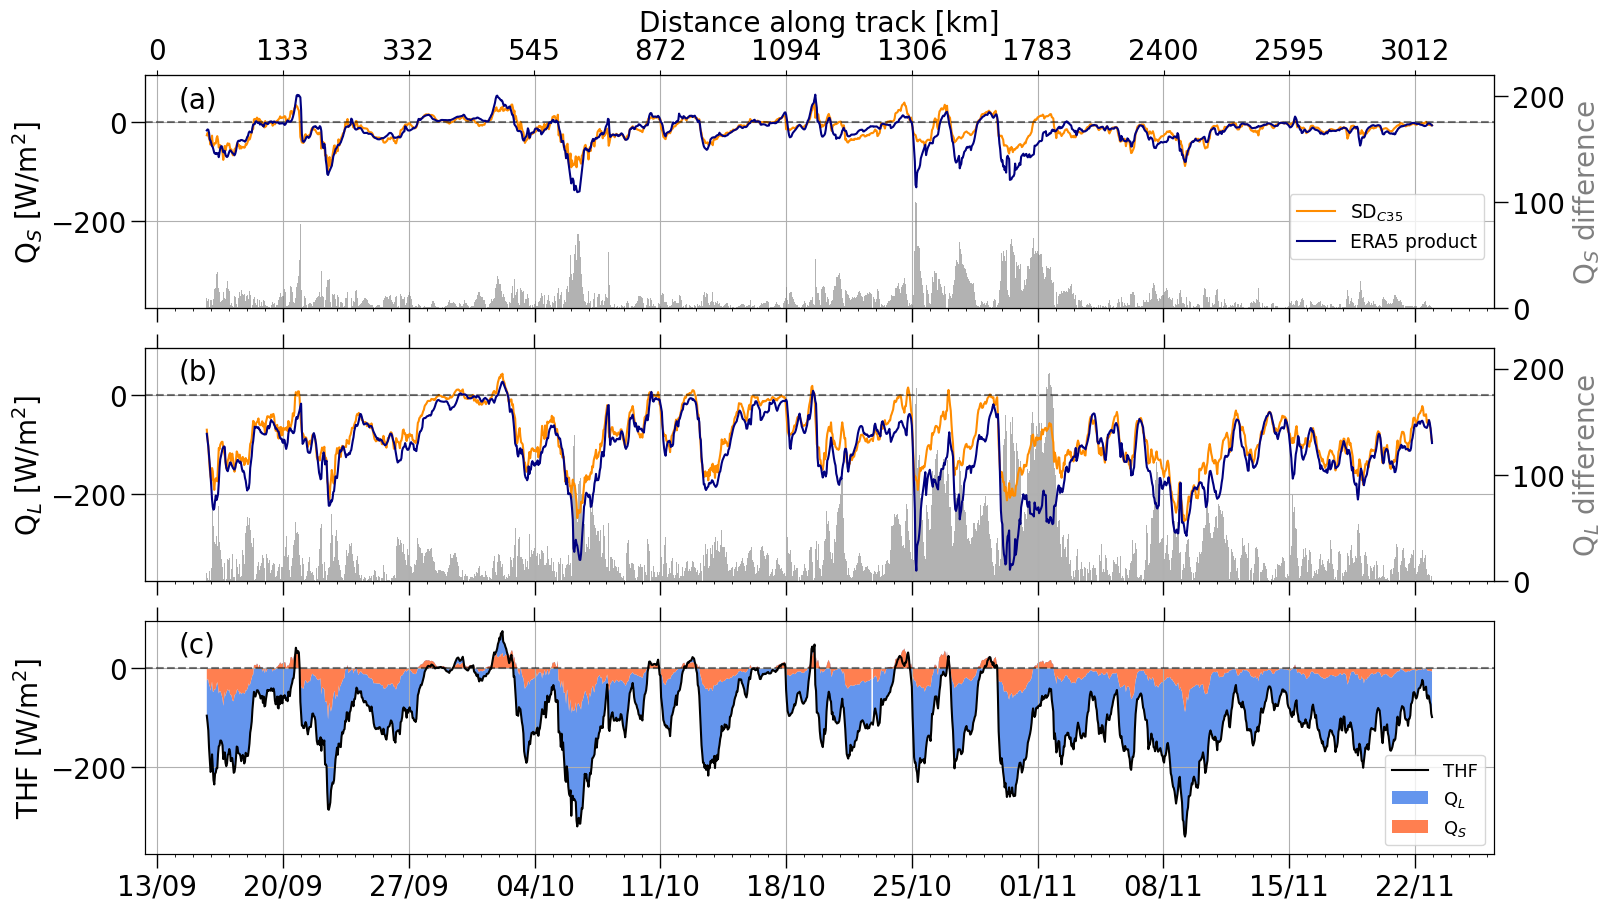

In [47]:

bajs=3
fig, ax=plt.subplots(bajs,1, figsize=[16,9], sharex=True, sharey=True, constrained_layout=True)


ax1=ax[0].twinx()
ax1.bar(dsadcpH.time, np.abs(SD_ASFC.sensible-coloc4.sensible),alpha=0.6,width=pd.Timedelta(hours=1), label='|SD-ERA5|', color='grey',zorder=0)

ax2=ax[1].twinx()
ax2.bar(dsadcpH.time, np.abs(SD_ASFC.latent-coloc4.latent),alpha=0.6,width=pd.Timedelta(hours=1), label='|SD-ERA5|', color='grey',zorder=0)


ax[0].plot(dsadcpH.time, SD_ASFC.sensible, label='SD$_{C35}$', c='darkorange', zorder=2)
ax[0].plot(dsadcpH.time, coloc4.sensible, label='ERA5 product',c='navy', zorder=3)
ax[0].set_ylabel('Q$_S$ [W/m$^2$]')

ax[1].plot(dsadcpH.time, SD_ASFC.latent, label='SD$_{C35}$', c='darkorange', zorder=2)
ax[1].plot(dsadcpH.time, coloc4.latent, label='ERA5 product',c='navy', zorder=3)
ax[1].set_ylabel('Q$_L$ [W/m$^2$]')

ax[2].plot(dsadcpH.time,  SD_ASFC.sensible+SD_ASFC.latent, c='k', label='THF')
ax[2].fill_between(dsadcpH.time,  SD_ASFC.sensible+SD_ASFC.latent, SD_ASFC.sensible, fc='cornflowerblue', label='Q$_L$')
ax[2].fill_between(dsadcpH.time,SD_ASFC.sensible, fc='coral', label='Q$_S$')


ax[0].legend(fontsize=13.5, loc='center right', bbox_to_anchor=(1.0,0.35))
ax[0].xaxis.set_minor_locator(mdates.DayLocator())

#bbox = dict(boxstyle="square", fc="0.8")

x=0.025
y=0.86

ax[0].annotate('(a)', xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
ax[1].annotate('(b)', xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
ax[2].annotate('(c)', xy=(x,y), xycoords='axes fraction')

for i in np.arange(bajs):
    ax[i].grid()
    ax[i].axhline(y=0, color='k', linestyle='--', alpha=0.5)

#    ax[i].legend()


ax[1].xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
myFmt = mdates.DateFormatter('%d'+'/'+'%m')
ax[1].xaxis.set_major_formatter(myFmt)
ax[1].xaxis.set_minor_locator(mdates.DayLocator())

ax[1].set_zorder(ax2.get_zorder() + 1)
ax[1].patch.set_visible(False)


ax[2].legend(loc='lower right', fontsize=13)
ax[2].set_ylabel('THF [W/m$^2$]')

ax1.set_ylim(0,220)
ax2.set_ylim(0,220)

ax1.set_ylabel('Q$_S$ difference', c='grey')
ax2.set_ylabel('Q$_L$ difference', c='grey')



ax5=ax[0].twiny()
ax5.plot(dsadcpH.time, dsadcpH['sst'], label='SD', color='darkorange', alpha=0)
ax5.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
xticks_timeunits = ax5.get_xticks()

#xticks_timeunits = np.linspace(mdates.date2num(np.min(dsadcpH.time.values)) , mdates.date2num(np.max(dsadcpH.time.values)) , 10)

def lookup_table(ticktime):
    index_of_nearest_time = np.argmin(np.abs(mdates.date2num(dsadcpH.time)-ticktime))
    return dist_along_track[index_of_nearest_time]
    
xticks_distanceunits = xticks_timeunits * np.NaN 
for idx, val in enumerate(xticks_timeunits):
    xticks_distanceunits[idx] = int(lookup_table(xticks_timeunits[idx]))
    
ticks=[]
for i in np.arange(len(xticks_timeunits)):
    ticks.append(int(xticks_distanceunits[i]))

xticks_distanceunits=np.array(ticks)

ax5.set_xticks(xticks_timeunits)
ax5.set_xticklabels(xticks_distanceunits)

ax6=ax[1].twiny()
ax6.plot(dsadcpH.time, dsadcpH['sst'], label='SD', color='darkorange', alpha=0)
ax7=ax[2].twiny()
ax7.plot(dsadcpH.time, dsadcpH['sst'], label='SD', color='darkorange', alpha=0)


ax6.set_xticks(xticks_timeunits)
ax6.set_xticklabels(xticks_distanceunits)

ax7.set_xticks(xticks_timeunits)
ax7.set_xticklabels(xticks_distanceunits)

ax[0].tick_params(axis='both', which='major', width=1, length=10)
ax[1].tick_params(axis='both', which='major', width=1, length=10)
ax[2].tick_params(axis='both', which='major', width=1, length=10)
ax1.tick_params(axis='both', which='major', width=1, length=10)
ax2.tick_params(axis='both', which='major', width=1, length=10)
ax6.tick_params(axis='both', which='major', width=1, length=10)
ax7.tick_params(axis='both', which='major', width=1, length=10)

ax6.set_xticklabels(['']*11)
ax7.set_xticklabels(['']*11)


ax5.set_xlabel('Distance along track [km]')

#ax[2].axhline(-260)
#ax1.axhline(95)
#ax2.axhline(180)



plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/final_figs/Flux_ts.png')

In [50]:
print('mean diff shf ' + str(np.nanmean(SD_ASFC.sensible-coloc4.sensible)))
print('mean diff lhf ' + str(np.nanmean(SD_ASFC.latent-coloc4.latent)))


print('max diff ' + str(np.nanmax((SD_ASFC.sensible+SD_ASFC.latent)-(coloc4.sensible+coloc4.latent))))
print('arg ' + str(np.nanargmax((SD_ASFC.sensible+SD_ASFC.latent)-(coloc4.sensible+coloc4.latent))))
print('time at max difference '+ str((dsadcpH["time"][948].values)))

mean diff shf 4.091613858414337
mean diff lhf 26.158285272682456
max diff 281.2517228416893
arg 948
time at max difference 2022-10-25T06:00:00.000000000


In [51]:
thf_diff=[]
lhf_diff=[]
shf_diff=[]

for i in np.arange(len(dsadcpH.time)-1):
    thf_diff.append((SD_ASFC.sensible+SD_ASFC.latent)[i]-(SD_ASFC.sensible+SD_ASFC.latent)[i+1])
    shf_diff.append((SD_ASFC.sensible)[i]-(SD_ASFC.sensible)[i+1])
    lhf_diff.append((SD_ASFC.latent)[i]-(SD_ASFC.latent)[i+1])

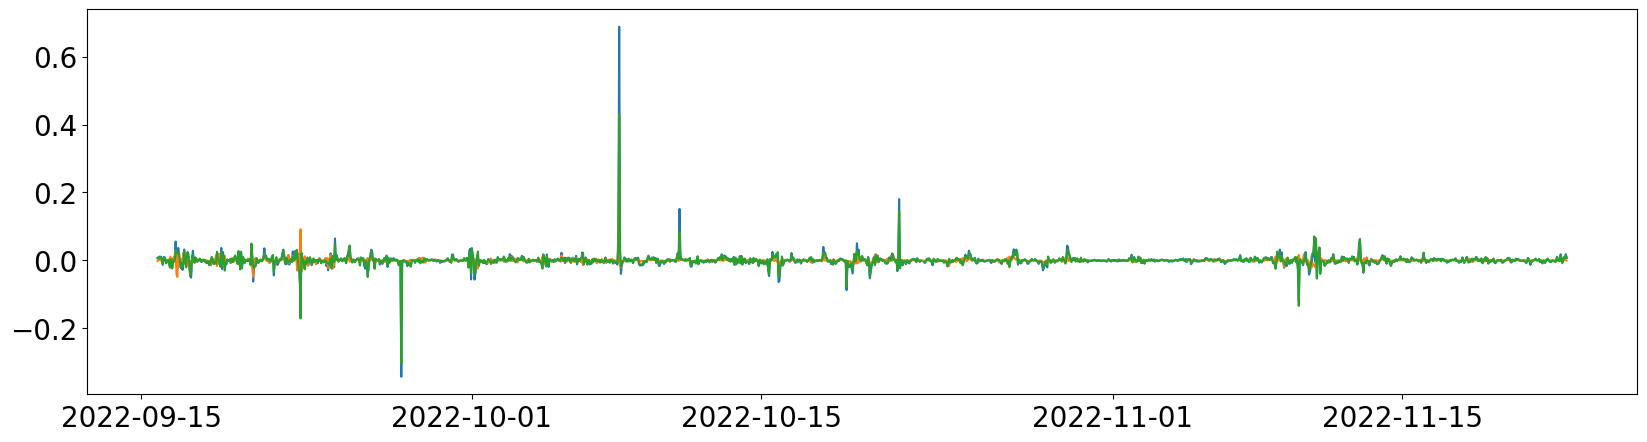

In [52]:
fig, ax=plt.subplots(figsize=[20,5])
ax.plot(dsadcpH.time[1:],  thf_diff/dsadcpH["dist_between_dp"][1:])
ax.plot(dsadcpH.time[1:],  shf_diff/dsadcpH["dist_between_dp"][1:])
ax.plot(dsadcpH.time[1:],  lhf_diff/dsadcpH["dist_between_dp"][1:])

In [53]:
np.nanargmax((thf_diff/dsadcpH["dist_between_dp"][1:]).values)

536

In [54]:
np.nanargmax((shf_diff/dsadcpH["dist_between_dp"][1:]).values)

536

In [55]:
np.nanargmax((lhf_diff/dsadcpH["dist_between_dp"][1:]).values)

536

In [56]:
(thf_diff/dsadcpH["dist_between_dp"][1:]).values[536]

0.6877948009009283

In [57]:
print((thf_diff)[536])
print(dsadcpH["dist_between_dp"][536].values)
print(dsadcpH["time"][536].values)

63.92023993246597
310.8057310354523
2022-10-08T02:00:00.000000000


In [58]:
print((lhf_diff)[536])
print(dsadcpH["dist_between_dp"][536].values)
print(dsadcpH["time"][536].values)

39.930976319022776
310.8057310354523
2022-10-08T02:00:00.000000000


In [59]:
print((shf_diff)[536])
print(dsadcpH["dist_between_dp"][536].values)
print(dsadcpH["time"][536].values)

23.989263613443192
310.8057310354523
2022-10-08T02:00:00.000000000


In [60]:
print(np.abs(SD_ASFC.sensible- coloc4.sensible).max())
print(np.abs(SD_ASFC.latent- coloc4.latent).max())

100.38941979175857
195.5991274540193


In [62]:
(SD_ASFC.sensible+SD_ASFC.latent).min()


(np.abs(SD_ASFC.sensible).mean()/np.abs(SD_ASFC.latent).mean())
#plt.plot(dsadcpH.time, np.abs(SD_ASFC.sensible)/np.abs(SD_ASFC.latent))

print('mean sensible ' + str(np.mean(SD_ASFC.sensible)))
print('std sensible ' + str(np.std(SD_ASFC.sensible)))
print('mean latent ' + str(np.mean(SD_ASFC.latent)))
print('std latent ' + str(np.std(SD_ASFC.latent)))

print('shf/lhf ' + str(np.nanmean(SD_ASFC.sensible)/np.nanmean(SD_ASFC.latent)))

mean sensible -14.660094207823386
std sensible 21.698399290665368
mean latent -85.16387687778035
std latent 54.428026532084296
shf/lhf 0.17213981731787825


## Terms timeseries

In [17]:
t_term=SD_rec.t_term.values
u_term_t=SD_rec.u_term_t.values
q_term=SD_rec.q_term.values
u_term_q=SD_rec.u_term_q.values
lhf_coeffs=SD_rec.lhf_coeffs.values
shf_coeffs=SD_rec.shf_coeffs.values
cov_term_t=SD_rec.cov_term_t.values
cov_term_q=SD_rec.cov_term_q.values
lhf_fluc=SD_rec.lhf_fluc.values
shf_fluc=SD_rec.shf_fluc.values
lhf_mean=SD_rec.lhf_mean.values
shf_mean=SD_rec.shf_mean.values
lhf_recomposed=SD_rec.lhf_recomposed.values
shf_recomposed=SD_rec.shf_recomposed.values



In [18]:
print('t_term', np.nanmax((shf_coeffs*t_term)), np.nanmin((shf_coeffs*t_term)))
print('u_term_t', np.nanmax((shf_coeffs*u_term_t)), np.nanmin((shf_coeffs*u_term_t)))
print('cov_term_t', np.nanmax((shf_coeffs*cov_term_t)), np.nanmin((shf_coeffs*cov_term_t)))


print('q_term', np.nanmax((lhf_coeffs*q_term)), np.nanmin((lhf_coeffs*q_term)))
print('u_term_q', np.nanmax((lhf_coeffs*u_term_q)), np.nanmin((lhf_coeffs*u_term_q)))
print('cov_term_q', np.nanmax((lhf_coeffs*cov_term_q)), np.nanmin((lhf_coeffs*cov_term_q)))

t_term 50.647975793649444 -52.960129455050314
u_term_t 15.167668388814837 -17.19455353281968
cov_term_t 33.63396789705641 -33.494772341703204
q_term 126.98052510667284 -154.66513351987211
u_term_q 91.47236471770391 -103.69599542880452
cov_term_q 96.71223435460621 -60.60368799017078


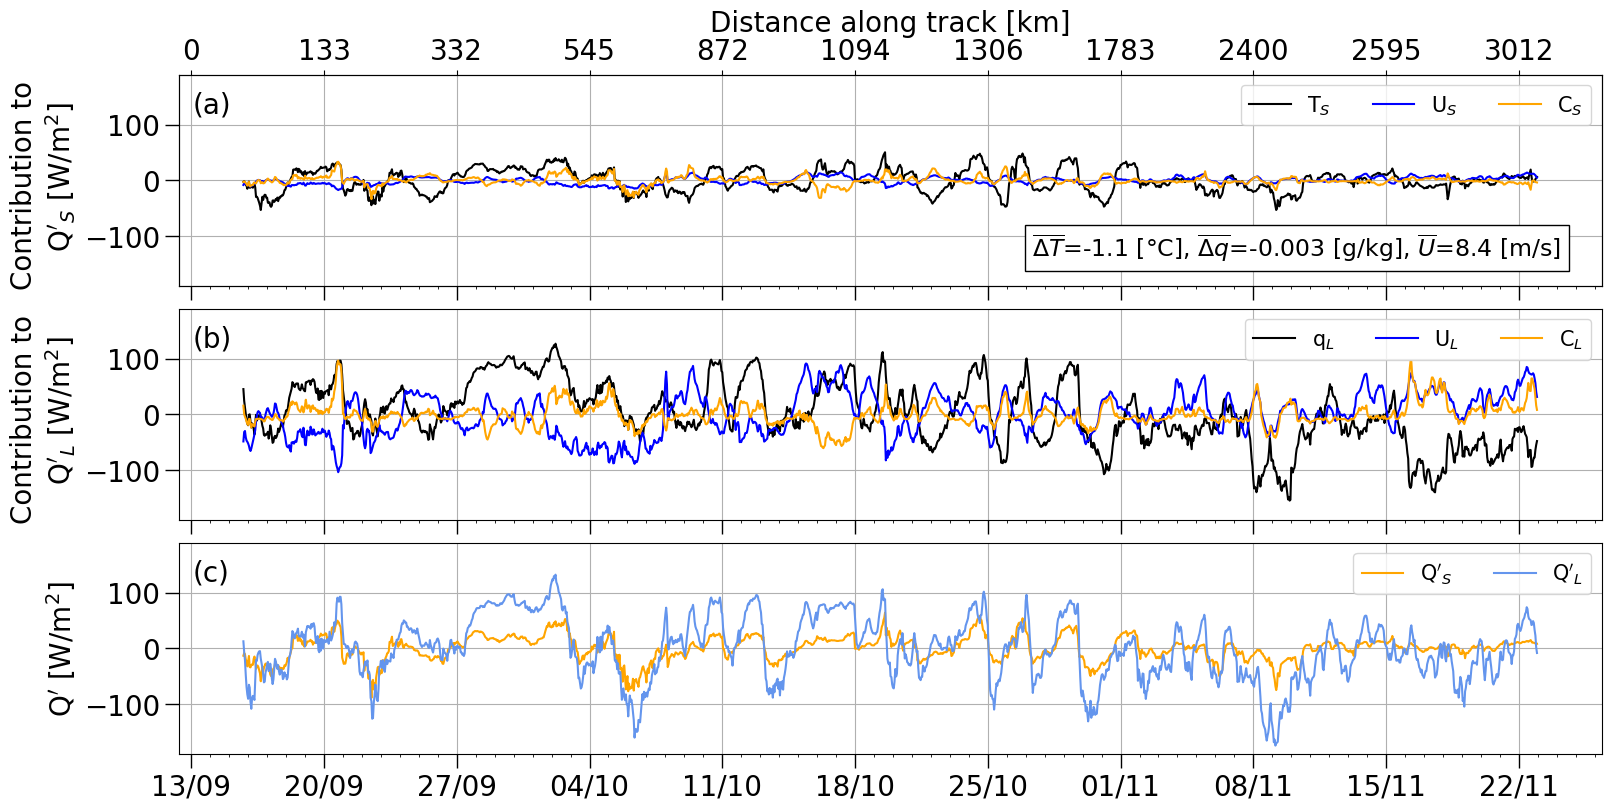

In [81]:
bajs=3

labelS = ['T$_S$', 'U$_S$', 'C$_S$', 'Q$^\prime$$_S$']
labelL = ['q$_L$', 'U$_L$', 'C$_L$', 'Q$^\prime$$_L$']

fig, ax=plt.subplots(bajs,1, figsize=[16,8], sharex=True, sharey=True,  constrained_layout=True)

ax[0].plot(dsadcpH.time, shf_coeffs*t_term, c='k', label=labelS[0])
ax[0].plot(dsadcpH.time, shf_coeffs*u_term_t, c='blue', label=labelS[1])
ax[0].plot(dsadcpH.time, shf_coeffs*cov_term_t, 'orange', label=labelS[2])



ax[1].plot(dsadcpH.time, lhf_coeffs*q_term, c='k', label=labelL[0])
ax[1].plot(dsadcpH.time, lhf_coeffs*u_term_q, c='blue', label=labelL[1])
ax[1].plot(dsadcpH.time, lhf_coeffs*cov_term_q, 'orange', label=labelL[2])


ax[2].plot(dsadcpH.time, shf_fluc, 'orange', label=labelS[3])
ax[2].plot(dsadcpH.time, lhf_fluc, 'cornflowerblue', label=labelL[3])

for i in np.arange(bajs):
    ax[i].grid()
    ax[i].legend(loc='upper right', fontsize=15, ncols=3)
#########SPATIAL AXIS##################


ax2=ax[0].twiny()
ax2.plot(dsadcpH.time, dsadcpH['sst'], alpha=0)
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
xticks_timeunits = ax2.get_xticks()

#xticks_timeunits = np.linspace(mdates.date2num(np.min(dsadcpH.time.values)) , mdates.date2num(np.max(dsadcpH.time.values)) , 10)

def lookup_table(ticktime):
    index_of_nearest_time = np.argmin(np.abs(mdates.date2num(dsadcpH.time)-ticktime))
    return dist_along_track[index_of_nearest_time]
    
xticks_distanceunits = xticks_timeunits * np.NaN 
for idx, val in enumerate(xticks_timeunits):
    xticks_distanceunits[idx] = int(lookup_table(xticks_timeunits[idx]))
    
ticks=[]
for i in np.arange(len(xticks_timeunits)):
    ticks.append(int(xticks_distanceunits[i]))

xticks_distanceunits=np.array(ticks)

ax2.set_xticks(xticks_timeunits)
ax2.set_xticklabels(xticks_distanceunits)

ax[0].tick_params(axis='both', which='major', width=1, length=10)
ax[1].tick_params(axis='both', which='major', width=1, length=10)
ax[2].tick_params(axis='both', which='major', width=1, length=10)

ax[1].xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
myFmt = mdates.DateFormatter('%d'+'/'+'%m')
ax[1].xaxis.set_major_formatter(myFmt)
ax[1].xaxis.set_minor_locator(mdates.DayLocator())
ax2.set_xlabel('Distance along track [km]')

#############################################

ax[0].set_ylabel('Contribution to \n Q$^\prime$$_S$ [W/m$^2$]')
ax[1].set_ylabel('Contribution to \n Q$^\prime$$_L$ [W/m$^2$]')
ax[2].set_ylabel('Q$^\prime$ [W/m$^2$]')

ax[1].set_ylim(-190,190)

x=0.01
y=0.82
ax[0].annotate('(a)', xy=(x,y), xycoords='axes fraction')
ax[1].annotate('(b)', xy=(x,y), xycoords='axes fraction')
ax[2].annotate('(c)', xy=(x,y), xycoords='axes fraction')

bbox = dict(boxstyle="square", facecolor='w')#, fc="0.8", facecolor='w')


ax[0].annotate('$\overline{\Delta T}$=-1.1 [°C], $\overline{\Delta q}$=-0.003 [g/kg], $\overline{U}$=8.4 [m/s]', xy=(0.6, 0.14), xycoords='axes fraction', bbox=bbox, fontsize=17)

plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/final_figs/terms_timeseries.png')

## Histograms & distribution

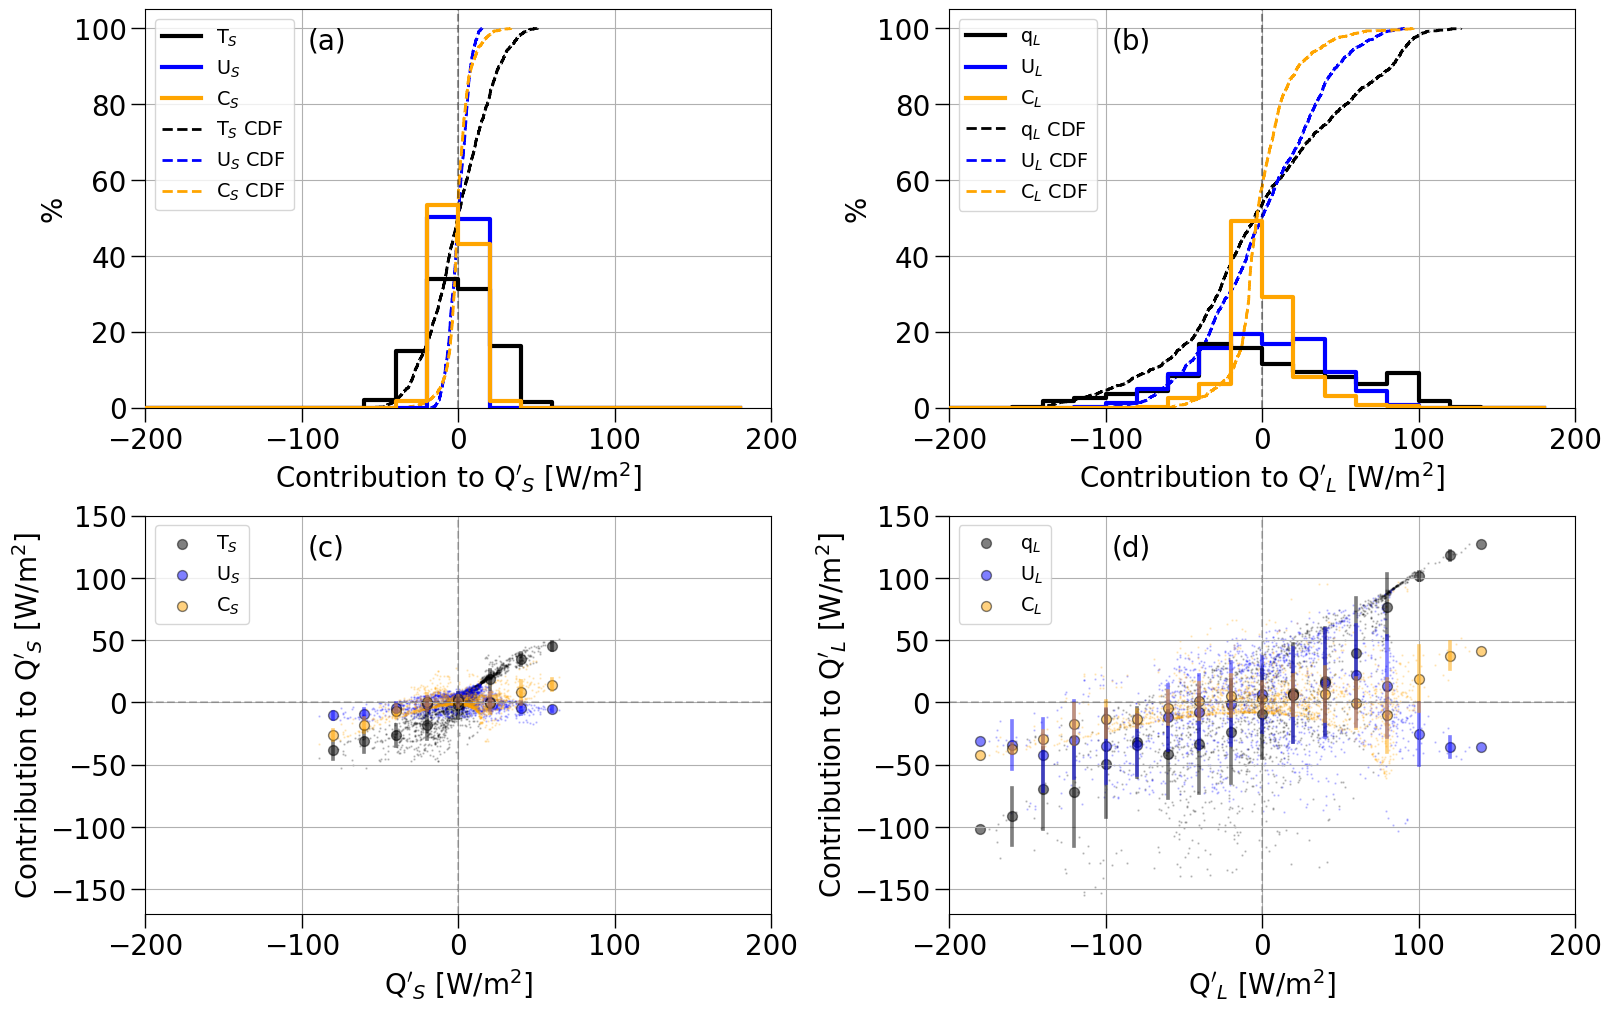

In [82]:
colors_s=['k', 'blue', 'orange']#['#1f4600', "#ff774c", "#b066dc"]
colors_l=['k', 'blue', 'orange']#["#3f316e", "#ff774c", "#b066dc"]

kde_setting=False
fill_setting=False


x_bins_s=np.arange(-100, 70, 20)
x_bins_l=np.arange(-200, 150, 20)

# Create a figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(2,2, figsize=[16, 10], constrained_layout=True)

# Lists defining keys for dictionaries
s_terms=[t_term, u_term_t, cov_term_t]
l_terms=[q_term, u_term_q, cov_term_q]

# Labels for the histograms
labelS = ['T$_S$', 'U$_S$', 'C$_S$']
labelL = ['q$_L$', 'U$_L$', 'C$_L$']

x_lbl=['Contribution to Q$^\prime$$_S$ [W/m$^2$]','Contribution to Q$^\prime$$_L$ [W/m$^2$]']


############################HISTOGRAMS###################################
# Number of bins for the histograms
bins = np.arange(-200, 200, 20)

# Transparency of the histograms
alpha = 1

# Create histograms and add them to the subplots
for i in np.arange(3):
    sns.histplot(shf_coeffs*s_terms[i],bins=bins,stat="percent", label=labelS[i],kde=kde_setting, ax=ax[0,0], alpha=alpha, element="step", color=colors_s[i],fill=fill_setting, linewidth=3,zorder=5)
    sns.histplot(lhf_coeffs*l_terms[i], bins=bins,stat="percent", label=labelL[i],kde=kde_setting, ax=ax[0,1],alpha=alpha, element="step", color=colors_l[i], fill=fill_setting, linewidth=3,zorder=5)

for i in np.arange(3):
    sns.ecdfplot(shf_coeffs*s_terms[i],stat="percent", label=labelS[i]+' CDF', ax=ax[0,0], alpha=alpha, color=colors_s[i], linewidth=2, linestyle='--')
    sns.ecdfplot(lhf_coeffs*l_terms[i],stat="percent", label=labelL[i]+' CDF', ax=ax[0,1],alpha=alpha, color=colors_l[i], linewidth=2, linestyle='--')

# Customize the subplots
for i in np.arange(2):
    ax[0,i].grid()
    ax[0,i].legend(fontsize='small', loc='upper left')
    ax[0,i].set_xlabel(x_lbl[i])
    ax[0,i].set_ylabel('%')

    # Set titles for the subplots
#    ax[0].set_title('Q$_S$')
#    ax[1].set_title('Q$_L$')
    
    # Add a dashed vertical line at x = 0
    ax[0,i].axvline(x=0, color='k', linestyle='--', alpha=0.4)
#    ax[0,i].set_ylim(0,1000)

bbox = dict(boxstyle="square", fc="0.8")



###################################################################################

#Plot the tiny scatters first so they end up behind big scatterpoints
for i in np.arange(3):
    sns.regplot(x=shf_fluc, y=shf_coeffs*s_terms[i], x_bins=None, ax=ax[1,0], fit_reg=False, scatter_kws=dict(s=0.5,  color=colors_s[i], alpha=0.2))
    sns.regplot(x=lhf_fluc, y=lhf_coeffs*l_terms[i], x_bins=None, ax=ax[1,1], fit_reg=False, scatter_kws=dict(s=0.5,  color=colors_l[i], alpha=0.2))

#Plot mean scatters with std
for i in np.arange(3):
    sns.regplot(x=shf_fluc, y=shf_coeffs*s_terms[i], x_bins=x_bins_s, ax=ax[1,0], fit_reg=False, label=labelS[i], x_ci='sd', scatter_kws=dict(alpha=0.5, color=colors_s[i], edgecolors='k'))
    

    sns.regplot(x=lhf_fluc, y=lhf_coeffs*l_terms[i], x_bins=x_bins_l, ax=ax[1,1], fit_reg=False, label=labelL[i], x_ci='sd', scatter_kws=dict(alpha=0.5, color=colors_l[i], edgecolors='k'))
    
    
 
#    ax[1].set_ylabel(labelL[i])


ax[1,1].grid() 
ax[1,1].legend(fontsize='x-small', loc='upper left')


ax[1,0].axvline(x=0, color='k', linestyle='--', alpha=0.2)
ax[1,1].axvline(x=0, color='k', linestyle='--', alpha=0.2)

ax[1,0].axhline(y=0, color='k', linestyle='--', alpha=0.2)
ax[1,1].axhline(y=0, color='k', linestyle='--', alpha=0.2)

#    ax[0].set_ylabel(labelS[i])
ax[1,0].grid()
ax[1,0].legend(fontsize='x-small', loc='upper left')
ax[0,0].legend(fontsize='x-small', loc='upper left')
ax[0,1].legend(fontsize='x-small', loc='upper left')


ax[1,0].set_xlabel('Q$^\prime$$_S$ [W/m$^2$]')
ax[1,1].set_xlabel('Q$^\prime$$_L$ [W/m$^2$]')

ax[1,0].set_ylabel('Contribution to Q$^\prime$$_S$ [W/m$^2$]')
ax[1,1].set_ylabel('Contribution to Q$^\prime$$_L$ [W/m$^2$]')
#ax[1].set_ylabel('Term of variability [W/m$^2$]')

#bbox = dict(boxstyle="square", fc="0.8")

ax[0,0].set_xlabel('Contribution to Q$^\prime$$_S$ [W/m$^2$]')
ax[0,1].set_xlabel('Contribution to Q$^\prime$$_L$ [W/m$^2$]')


#############################################################
x=0.26
y=0.9
ax[0,0].annotate('(a)', xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
ax[0,1].annotate('(b)', xy=(x,y), xycoords='axes fraction')#, bbox=bbox)

ax[1,0].annotate('(c)', xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
ax[1,1].annotate('(d)', xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
ax[0,0].set_xlim(-200,200) 
ax[0,1].set_xlim(-200,200) 
ax[1,0].set_xlim(-200,200) 
ax[1,1].set_xlim(-200,200)

ax[1,0].set_ylim(-170,150) 
ax[1,1].set_ylim(-170,150)

ax[0,0].tick_params(axis='both', which='major', width=1, length=10)
ax[0,1].tick_params(axis='both', which='major', width=1, length=10)
ax[1,0].tick_params(axis='both', which='major', width=1, length=10)
ax[1,1].tick_params(axis='both', which='major', width=1, length=10)


plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/final_figs/SD_hist_CDE.png')

(-200.0, 200.0)

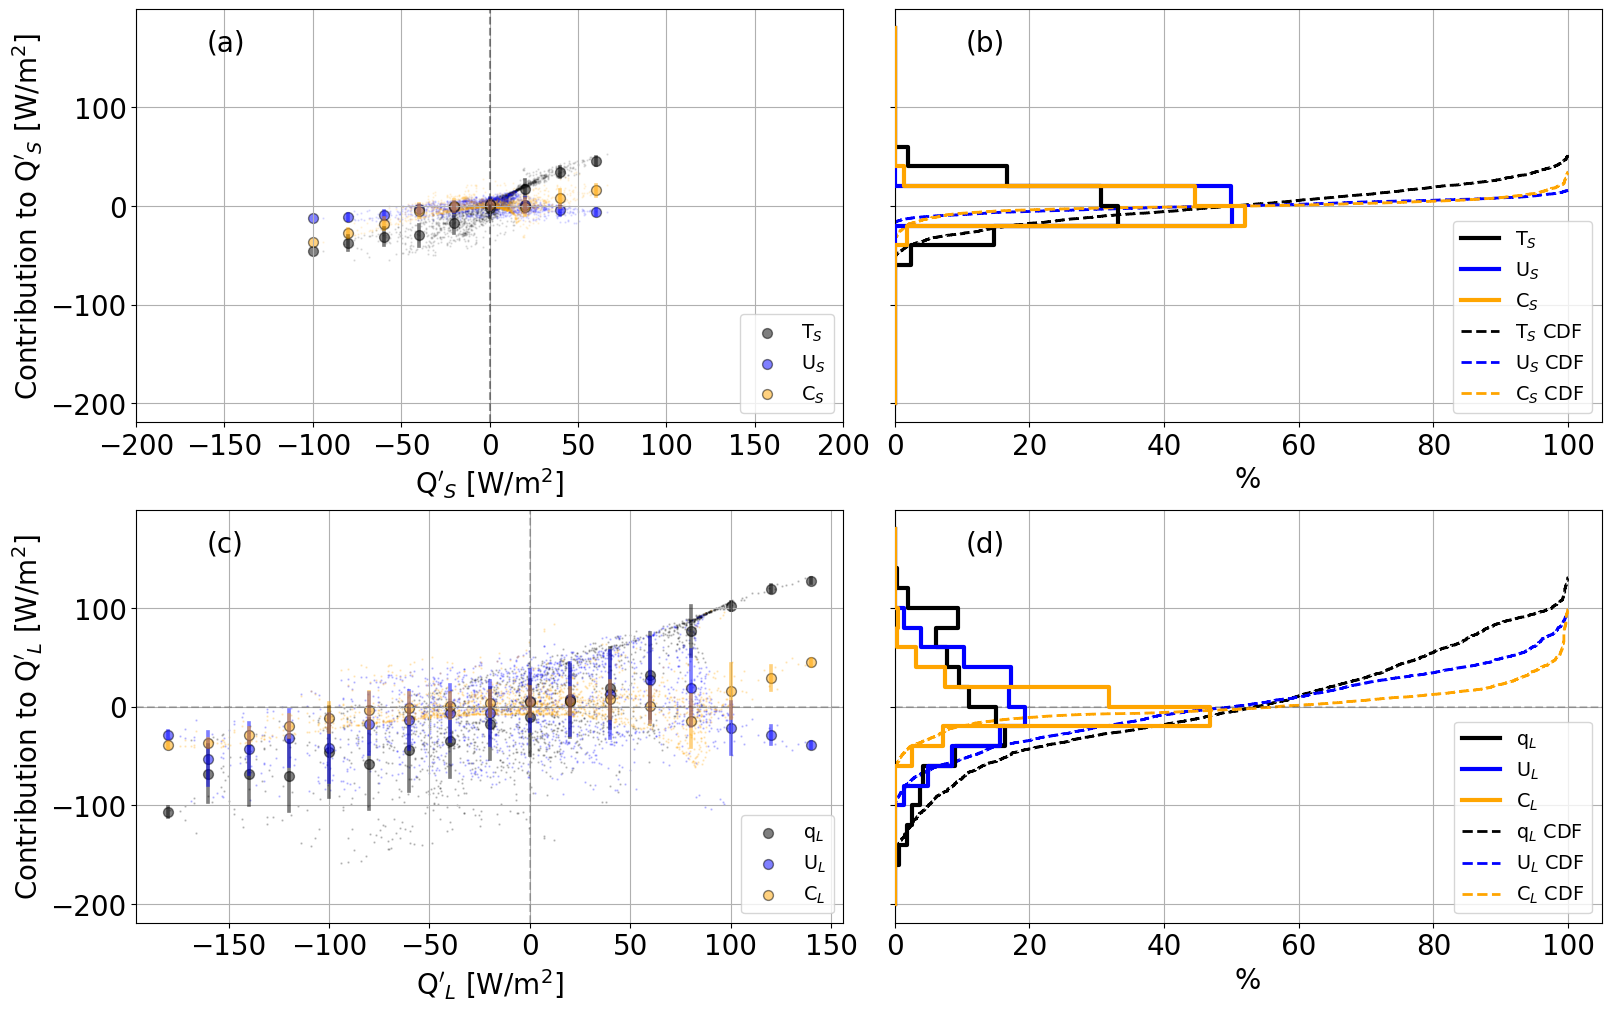

In [52]:
colors_s=['k', 'blue', 'orange']#['#1f4600', "#ff774c", "#b066dc"]
colors_l=['k', 'blue', 'orange']#["#3f316e", "#ff774c", "#b066dc"]

kde_setting=False
fill_setting=False

# Create a figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(2,2, figsize=[16, 10], constrained_layout=True, sharey=True)

# Lists defining keys for dictionaries
s_terms=[t_term, u_term_t, cov_term_t]
l_terms=[q_term, u_term_q, cov_term_q]

# Labels for the histograms
labelS = ['T$_S$', 'U$_S$', 'C$_S$']
labelL = ['q$_L$', 'U$_L$', 'C$_L$']

x_lbl=['Contribution to Q$^\prime$$_S$ [W/m$^2$]','Contribution to Q$^\prime$$_L$ [W/m$^2$]']


############################HISTOGRAMS###################################
# Number of bins for the histograms
bins = np.arange(-200, 200, 20)

# Transparency of the histograms
alpha = 1

# Create histograms and add them to the subplots
for i in np.arange(3):
    sns.histplot(y=shf_coeffs*s_terms[i],bins=bins,stat="percent", label=labelS[i],kde=kde_setting, ax=ax[0,1], alpha=alpha, element="step", color=colors_s[i],fill=fill_setting, linewidth=3,zorder=5)
    sns.histplot(y=lhf_coeffs*l_terms[i], bins=bins,stat="percent", label=labelL[i],kde=kde_setting, ax=ax[1,1],alpha=alpha, element="step", color=colors_l[i], fill=fill_setting, linewidth=3,zorder=5)

for i in np.arange(3):
    sns.ecdfplot(y=shf_coeffs*s_terms[i],stat="percent", label=labelS[i]+' CDF', ax=ax[0,1], alpha=alpha, color=colors_s[i], linewidth=2, linestyle='--')
    sns.ecdfplot(y=lhf_coeffs*l_terms[i],stat="percent", label=labelL[i]+' CDF', ax=ax[1,1],alpha=alpha, color=colors_l[i], linewidth=2, linestyle='--')

    # Set titles for the subplots
#    ax[0].set_title('Q$_S$')
#    ax[1].set_title('Q$_L$')
    
    # Add a dashed vertical line at x = 0
#    ax[0,i].set_ylim(0,1000)

bbox = dict(boxstyle="square", fc="0.8")



###################################################################################

#Plot the tiny scatters first so they end up behind big scatterpoints
for i in np.arange(3):
    sns.regplot(x=shf_fluc, y=shf_coeffs*s_terms[i], x_bins=None, ax=ax[0,0], fit_reg=False, scatter_kws=dict(s=0.5,  color=colors_s[i], alpha=0.1))
    sns.regplot(x=lhf_fluc, y=lhf_coeffs*l_terms[i], x_bins=None, ax=ax[1,0], fit_reg=False, scatter_kws=dict(s=0.5,  color=colors_l[i], alpha=0.2))

#Plot mean scatters with std
for i in np.arange(3):
    sns.regplot(x=shf_fluc, y=shf_coeffs*s_terms[i], x_bins=x_bins_s, ax=ax[0,0], fit_reg=False, label=labelS[i], x_ci='sd', scatter_kws=dict(alpha=0.5, color=colors_s[i], edgecolors='k'))
    

    sns.regplot(x=lhf_fluc, y=lhf_coeffs*l_terms[i], x_bins=x_bins_l, ax=ax[1,0], fit_reg=False, label=labelL[i], x_ci='sd', scatter_kws=dict(alpha=0.5, color=colors_l[i], edgecolors='k'))
    
    
 
#    ax[1].set_ylabel(labelL[i])


ax[1,1].grid() 


ax[1,0].axvline(x=0, color='k', linestyle='--', alpha=0.2)
ax[1,1].axvline(x=0, color='k', linestyle='--', alpha=0.2)

ax[1,0].axhline(y=0, color='k', linestyle='--', alpha=0.2)
ax[1,1].axhline(y=0, color='k', linestyle='--', alpha=0.2)

#    ax[0].set_ylabel(labelS[i])
ax[1,0].grid()
ax[1,1].legend(fontsize='x-small', loc='lower right')
ax[1,0].legend(fontsize='x-small', loc='lower right')
ax[0,0].legend(fontsize='x-small', loc='lower right')
ax[0,1].legend(fontsize='x-small', loc='lower right')


ax[0,0].set_xlabel('Q$^\prime$$_S$ [W/m$^2$]')
ax[1,0].set_xlabel('Q$^\prime$$_L$ [W/m$^2$]')

ax[0,0].set_ylabel('Contribution to Q$^\prime$$_S$ [W/m$^2$]')
ax[1,0].set_ylabel('Contribution to Q$^\prime$$_L$ [W/m$^2$]')
#ax[1].set_ylabel('Term of variability [W/m$^2$]')


# Customize the subplots
for i in np.arange(2):
    ax[0,i].grid()
    ax[0,i].axvline(x=0, color='k', linestyle='--', alpha=0.4)
    ax[i,1].set_xlabel('%')
#    ax[i,1].set_ylabel('%')

bbox = dict(boxstyle="square", fc="0.8")


#############################################################
x=0.1
y=0.9
ax[0,0].annotate('(a)', xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
ax[0,1].annotate('(b)', xy=(x,y), xycoords='axes fraction')#, bbox=bbox)

ax[1,0].annotate('(c)', xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
ax[1,1].annotate('(d)', xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
ax[0,0].set_xlim(-200,200) 

## Upscale

In [6]:
rec_ds_qTU=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleERA5_qTU.nc')
rec_ds_increased_iter=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleERA5_Tq_mean_increased_ite.nc')
rec_ds_out_1=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleERA5_out_1.nc')

In [16]:
def plot_upscale(linewidth, time, vmin_l, vmax_l, vmin_s, vmax_s, cmap='RdBu_r',bbox = dict(boxstyle="square", fc='w'),ssh_plot=1, eddy_plot=0, ani_fig_save=0, figsize=[16,15]):
    
    fig, ax=plt.subplots(3,2, figsize=figsize, sharey=True, constrained_layout=True, sharex=True,subplot_kw={'projection':ccrs.PlateCarree()})
    
    
    ax[0,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.shf_fluc.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
    ax[1,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.t_term.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
    cbar_s=ax[2,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_t.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
    #ax[3,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_t.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
    #plt.colorbar(cbar_s, ax=ax[0,2+1], label='Contribution to Q$^\prime _{S}$ [W/m$^2$] ')
    
    
    ax[0,1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.lhf_fluc.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
    ax[1,1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.q_term.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
    cbar_l=ax[2,1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_q.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
    #ax[3,1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_q.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
    
    cax = ax[0,1].inset_axes([0.05, 1.05, 0.9, 0.1])
    cbar=fig.colorbar(cbar_l, cax=cax, label=('Contribution to Q$^\prime$ [W/m$^2$] '), orientation='horizontal', location='top')
    
#    cbar.ax.tick_params(labelsize=20)
    
    
    #plt.colorbar(cbar_l, ax=ax[1,3], label='Contribution to Q$^\prime$ [W/m$^2$] ', orientation='horizontal')
    
    alpha=0.4
    
    ax[0,0].grid(alpha=alpha)
    ax[1,0].grid(alpha=alpha)
    ax[2,0].grid(alpha=alpha)
    #ax[3,0].grid(alpha=alpha)
    
    ax[0,1].grid(alpha=alpha)
    ax[1,1].grid(alpha=alpha)
    ax[2,1].grid(alpha=alpha)
    #ax[3,1].grid(alpha=alpha)
    
    '''
    ax[0,1].set_xlabel('Longitude [°E]')
    ax[1,1].set_xlabel('Longitude [°E]')
    ax[2,1].set_xlabel('Longitude [°E]')
    ax[3,1].set_xlabel('Longitude [°E]')
    
    #ax[0,0].set_ylabel('Latitude [°N]')
    #ax[1,0].set_ylabel('Latitude [°N]')
    ax[0,0].set_title('Q$^\prime$$_S$')
    ax[1,0].set_title('T$_S$-term')
    ax[2,0].set_title('U$_S$-term')
    ax[3,0].set_title('C$_S$-term')
    
    ax[0,1].set_title('Q$^\prime$$_L$')
    ax[1,1].set_title('q$_L$-term')
    ax[2,1].set_title('U$_L$-term')
    ax[3,1].set_title('C$_L$-term')
    '''
    
    fig_labels=[['(a) Q$^\prime$$_S$','(b) T$_S$-term','(c) U$_S$-term','(d) C$_S$-term'],['(d) Q$^\prime$$_L$','(e) q$_L$-term','(f) U$_L$-term','(h) C$_L$-term']]

    #fig_labels=[['(a)','(b) ','(c) ','(d) '],['(e)','(f)','(g)','(h)']]
    
    x=0.018
    y=0.9
    font=25
    
    ax[0,0].annotate(fig_labels[0][0], xy=(x,y), xycoords='axes fraction', fontsize=font)#, bbox=bbox)
    ax[1,0].annotate(fig_labels[0][1], xy=(x,y), xycoords='axes fraction', fontsize=font)#, bbox=bbox)
    ax[2,0].annotate(fig_labels[0][2], xy=(x,y), xycoords='axes fraction', fontsize=font)#, bbox=bbox)
    #ax[3,0].annotate(fig_labels[0][3], xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
    
    ax[0,1].annotate(fig_labels[1][0], xy=(x,y), xycoords='axes fraction', fontsize=font)#, bbox=bbox)
    ax[1,1].annotate(fig_labels[1][1], xy=(x,y), xycoords='axes fraction', fontsize=font)#, bbox=bbox)
    ax[2,1].annotate(fig_labels[1][2], xy=(x,y), xycoords='axes fraction', fontsize=font)#, bbox=bbox)
    #ax[3,1].annotate(fig_labels[1][3], xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
    
    ToF_bottom1=[False, False, True, True]
    ToF_left1=[True, True, True, True]
    
    ToF_bottom=[False, False, True, True]
    ToF_left=[False, False, False, False]
    
    # Add land and coastline
    for i in np.arange(3):    
        ax[i,1].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)
        ax[i,0].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)
    
        #ax[i,0].scatter(dsadcpH.longitude[:time], dsadcpH.latitude[:time], s=30, color='grey', alpha=0.2,label='SD 1067 path')
        #ax[i,0].scatter(dsadcpH.longitude[time], dsadcpH.latitude[time], s=50, color='darkorange', marker='^', alpha=0.8, edgecolor='k',label='SD 1067')
        
    
        #ax[i,1].scatter(dsadcpH.longitude[:time], dsadcpH.latitude[:time], s=30, color='grey', alpha=0.2,label='SD 1067 path')
        #ax[i,1].scatter(dsadcpH.longitude[time], dsadcpH.latitude[time], s=50, color='darkorange', marker='^', alpha=0.8, edgecolor='k',label='SD 1067')
    
    
        
        for k,spine in ax[i,0].spines.items():  #ax.spines is a dictionary
                spine.set_zorder(12)
                gridlines(ax[i,0],5,5, ToF_bottom1[i], ToF_left1[i])
        
        for k,spine in ax[i,1].spines.items():  #ax.spines is a dictionary
                spine.set_zorder(12)
                gridlines(ax[i,1],5,5, ToF_bottom[i], ToF_left[i])
    
    
    
    ax[0,1].annotate((pd.to_datetime(rec_ds.time[time].values).strftime("%d/%m, %H:%M")), xy=(0.65, 0.9), xycoords='axes fraction',fontsize=20)#, bbox=bbox)
    
    
    ax[1,0].set_xlim(rec_ds.longitude.min(),rec_ds.longitude.max())
    ax[1,0].set_ylim(rec_ds.latitude.min(),rec_ds.latitude.max())       
    
    #EDDIES
    ''' 
    if eddy_plot == 1:
        for i in np.arange(len(eddies)):
            d = eddies[i]['date_num']
        
            py_date = np.datetime64(datetime.datetime.fromordinal(int(d)) + datetime.timedelta(days=d % 1) - datetime.timedelta(days=366), 'ms')
            if py_date.astype('datetime64[D]') == rec_ds.time[time].values.astype('datetime64[D]'):
                for frame in np.arange(4):
                    plot_eddies(eddies[i], ax[0,frame])
                    plot_eddies(eddies[i], ax[1,frame])
                break
    '''

    if ssh_plot==1:
        for ssh in np.arange(len(SSH.time)):
            d = SSH.time.isel(time=ssh)
        
            if d.astype('datetime64[D]') == rec_ds.time[time].values.astype('datetime64[D]'):
                for frame in np.arange(3):
                    ax[frame,0].contour(SSH.longitude, SSH.latitude, SSH.isel(time=ssh).adt, colors='dimgray', zorder=1, levels=np.arange(-1.8, 1, 0.2), alpha=0.7,linewidths=linewidth)
                    ax[frame,1].contour(SSH.longitude, SSH.latitude, SSH.isel(time=ssh).adt, colors='dimgray', zorder=1, levels=np.arange(-1.8, 1, 0.2), alpha=0.7,linewidths=linewidth)
                    
                    ax[frame,0].contour(SSH.longitude, SSH.latitude, SSH.isel(time=ssh).adt, colors='orange', zorder=1, levels=[0.6],linewidths=linewidth)
                    ax[frame,1].contour(SSH.longitude, SSH.latitude, SSH.isel(time=ssh).adt, colors='orange', zorder=1, levels=[0.6],linewidths=linewidth)

    
    #ax[1,1].legend(bbox_to_anchor=[0.67, -0.13], ncols=2)
    ERA5time=ERA5big.isel(time=time)
    longitudes=ERA5time.longitude[0::6].values
    latitudes=ERA5time.latitude[0::6].values

    ERA5time=ERA5time.sel(longitude=longitudes, latitude=latitudes)
    for i in np.arange(3):
        ax[i,0].quiver(ERA5time.longitude, ERA5time.latitude, ERA5time.u10, ERA5time.v10, alpha=0.3)#, ERA5time.rh)#np.sqrt((ERA5time.u10**2+ERA5time.v10**2)))
        ax[i,1].quiver(ERA5time.longitude, ERA5time.latitude, ERA5time.u10, ERA5time.v10, alpha=0.3)#, ERA5time.rh)#np.sqrt((ERA5time.u10**2+ERA5time.v10**2)))


    if ani_fig_save==1:
        plt.savefig(pathlib.Path('.').absolute().parent/ f'MTmichaela/ani_fig/pic_{time:04}.png')
    else:
        plt.show()
        
#    plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/test.png')
#    plt.tight_layout()

    plt.close(fig)
#ax[1,0].xaxis.set_ticks(ticks=np.arange(0,30,5), labels=[0,10,20,30])

In [17]:

vmin_l=-100
vmax_l=100

vmin_s=vmin_l
vmax_s=vmax_l
cmap='RdBu_r'

linewidth=2.5
rec_ds=rec_ds_qTU#rec_ds_ERA5#rec_ds_qT

#eddy_plot=1 #Plot eddies or not, =1 plots eddies

In [19]:
#4/10, 442
time=442
plot_upscale(linewidth, time, vmin_l, vmax_l, vmin_s=vmin_l, vmax_s=vmax_l, cmap='RdBu_r',bbox = dict(boxstyle="square", fc='w'), ani_fig_save=1,ssh_plot=1, eddy_plot=0, figsize=[16,14])

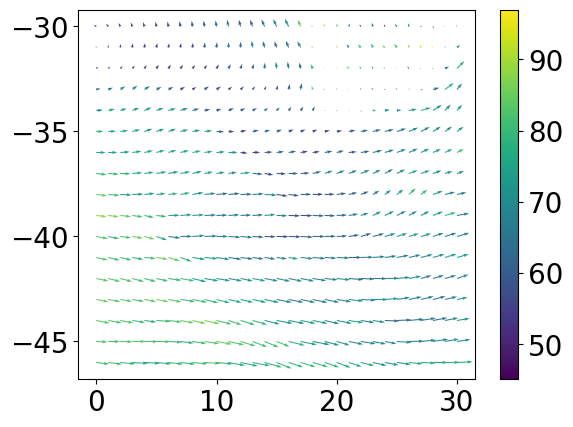

In [108]:
ERA5time=ERA5big.isel(time=442)
longitudes=ERA5time.longitude[0::4].values
latitudes=ERA5time.latitude[0::4].values

ERA5time=ERA5time.sel(longitude=longitudes, latitude=latitudes)

plt.quiver(ERA5time.longitude, ERA5time.latitude, ERA5time.u10, ERA5time.v10, ERA5time.rh)#np.sqrt((ERA5time.u10**2+ERA5time.v10**2)))
plt.colorbar()

In [11]:
rec_ds=rec_ds_ERA5 #Choose dataset


for time in tqdm(np.arange(1541, len(rec_ds.time))):
    plot_upscale(time, vmin_l, vmax_l, vmin_s=vmin_l, vmax_s=vmax_l, cmap='RdBu_r',bbox = dict(boxstyle="square", fc='w'), ani_fig_save=1,ssh_plot=1, eddy_plot=0, figsize=[16,18.0])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [08:00<00:00,  4.96s/it]


In [12]:
import moviepy.video.io.ImageSequenceClip
image_folder=pathlib.Path('.').absolute().parent/ 'MTmichaela/ani_fig'
fps=12

image_files = [os.path.join(image_folder,img)
               for img in np.sort(os.listdir(image_folder))
               if img.endswith(".png")]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('terms_out_1.mp4')

Moviepy - Building video terms_out_1.mp4.
Moviepy - Writing video terms_out_1.mp4



Moviepy - Done !
Moviepy - video ready terms_out_1.mp4


## Upscale R2

In [5]:
rec_r2_out_1=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleCORR_R2_out_1.nc') #ds with kept unrealistic values

In [12]:
np.arange(0, 1.1, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

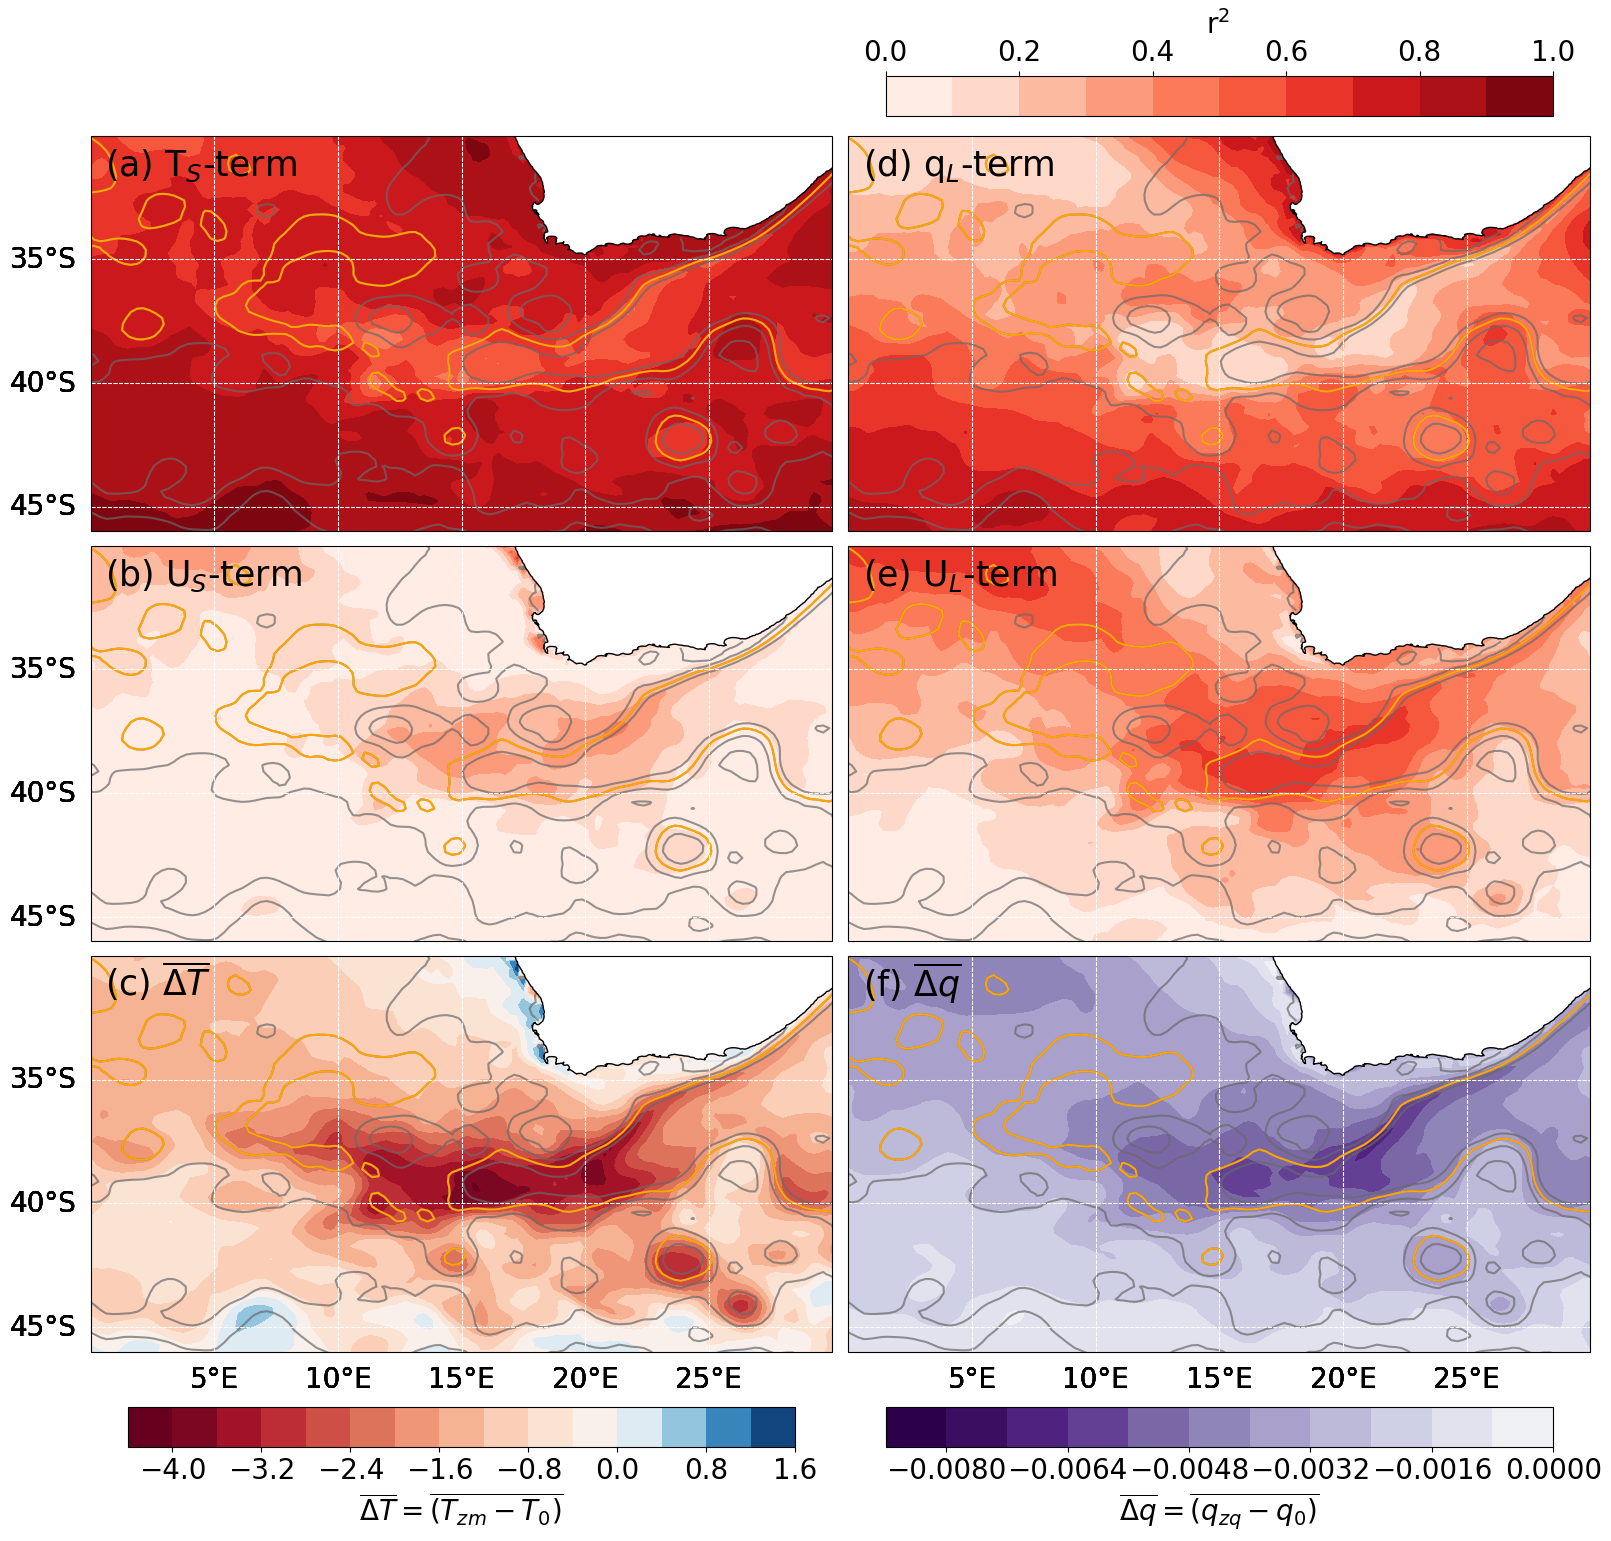

In [8]:

from matplotlib.colors import TwoSlopeNorm
#time=100
vmin_l=0
vmax_l=1

vmin_s=vmin_l
vmax_s=vmax_l
cmap='Reds'
cmap2='Greys'

cmapT='RdBu'
cmapq='PuOr_r'
levels=np.arange(0, 1.1, 0.1)
levels2=10

vmin_T=None#-4
vmax_T=None#1.4
levels_T=15

vmin_q=None#-0.05
vmax_q=None#0.05
levels_q=10

adt_levels=np.arange(-1.8, 1, 0.2)

rec_ds=rec_r2#rec_r2_out_1#rec_r2
bbox = dict(boxstyle="square", fc='w')

fig, ax=plt.subplots(3,2, figsize=[16,15.3], constrained_layout=True, sharey=True, sharex=True,subplot_kw={'projection':ccrs.PlateCarree()})

#ax[0,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.shf_fluc)#, vmin=vmin_s, vmax=vmax_s, cmap=cmap )

ax[0,0].contourf(ERA5big.longitude, ERA5big.latitude, rec_ds.t_term, vmin=vmin_s, vmax=vmax_s, cmap=cmap, levels=levels )
ax[1,0].contourf(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_t, vmin=vmin_s, vmax=vmax_s, cmap=cmap , levels=levels)

norm = TwoSlopeNorm(vmin=rec_ds_qTU.isel(time=5).T_bar.min().values, vcenter=0, vmax=rec_ds_qTU.isel(time=5).T_bar.max().values )
T_cbar=ax[2,0].contourf(ERA5big.longitude, ERA5big.latitude, rec_ds_qTU.isel(time=5).T_bar,levels=levels_T, cmap=cmapT, vmin=vmin_T, vmax=vmax_T, norm=norm )

#ax[0,0].contour(ERA5big.longitude, ERA5big.latitude, rec_ds.t_term, vmin=vmin_s, vmax=vmax_s, cmap=cmap2, levels=levels2 )
#ax[0,1].contour(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_t, vmin=vmin_s, vmax=vmax_s, cmap=cmap2 , levels=levels2)
#ax[0,2].contour(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_t, vmin=vmin_s, vmax=vmax_s, cmap=cmap2, levels=levels2 )
#plt.colorbar(cbar_s, ax=ax[0,2+1], label='Contribution to Q$^\prime _{S}$ [W/m$^2$] ')


#ax[1,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.lhf_fluc)#, vmin=vmin_l, vmax=vmax_l, cmap=cmap )
ax[0,1].contourf(ERA5big.longitude, ERA5big.latitude, rec_ds.q_term, vmin=vmin_l, vmax=vmax_l, cmap=cmap, levels=levels )
cbar_l=ax[1,1].contourf(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_q, vmin=vmin_l, vmax=vmax_l, cmap=cmap, levels=levels )

norm = TwoSlopeNorm(vmin=rec_ds_qTU.isel(time=5).q_bar.min().values, vcenter=0, vmax=0.1 )
q_cbar=ax[2,1].contourf(ERA5big.longitude, ERA5big.latitude, rec_ds_qTU.isel(time=5).q_bar, levels=levels_q, cmap=cmapq, vmin=vmin_q, vmax=vmax_q, norm=norm )


ax[0,0].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), colors='dimgray', levels=adt_levels, alpha=0.7)
ax[1,0].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), colors='dimgray', levels=adt_levels, alpha=0.7)
ax[2,0].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), colors='dimgray', levels=adt_levels, alpha=0.7)

ax[0,1].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), colors='dimgray', levels=adt_levels, alpha=0.7)
ax[1,1].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), colors='dimgray', levels=adt_levels, alpha=0.7)
ax[2,1].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), colors='dimgray', levels=adt_levels, alpha=0.7)


ax[0,0].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), colors='orange', levels=[0.6])
ax[1,0].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), colors='orange', levels=[0.6])
ax[2,0].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), colors='orange', levels=[0.6])

ax[0,1].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), colors='orange', levels=[0.6])
ax[1,1].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), colors='orange', levels=[0.6])
ax[2,1].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), colors='orange', levels=[0.6])

#ax[1,0].contour(ERA5big.longitude, ERA5big.latitude, rec_ds.q_term, vmin=vmin_l, vmax=vmax_l, cmap=cmap2, levels=levels2 )
#ax[1,1].contour(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_q, vmin=vmin_l, vmax=vmax_l, cmap=cmap2, levels=levels2 )
#ax[1,2].contour(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_q, vmin=vmin_l, vmax=vmax_l, cmap=cmap2, levels=levels2 )


#plt.colorbar(cbar_l, ax=ax[1,3], label='Contribution to Q$^\prime$ [W/m$^2$] ', orientation='horizontal')


#ax[1,2].set_title('C$_L$-term')
alpha=0.4

#ax[0,0].grid(alpha=alpha)
ax[0,0].grid(alpha=alpha)
ax[1,0].grid(alpha=alpha)
ax[2,0].grid(alpha=alpha)

#ax[1,0].grid(alpha=alpha)
ax[0,1].grid(alpha=alpha)
ax[1,1].grid(alpha=alpha)
ax[2,1].grid(alpha=alpha)

    
ToF_bottom1=[False, False, True, True]
ToF_left1=[True, True, True, True]

ToF_bottom=[False, False, True, True]
ToF_left=[False, False, False, False]

# Add land and coastline
for i in np.arange(3):    
    ax[i,0].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)
    ax[i,1].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)

#    ax[0,i].scatter(dsadcpH.longitude[:time], dsadcpH.latitude[:time], s=30, color='grey', alpha=0.2,label='SD 1067 path')
#    ax[0,i].scatter(dsadcpH.longitude[time], dsadcpH.latitude[time], s=50, color='darkorange', marker='^', alpha=0.8, edgecolor='k',label='SD 1067')
    

#    ax[1,i].scatter(dsadcpH.longitude[:time], dsadcpH.latitude[:time], s=30, color='grey', alpha=0.2,label='SD 1067 path')
#    ax[1,i].scatter(dsadcpH.longitude[time], dsadcpH.latitude[time], s=50, color='darkorange', marker='^', alpha=0.8, edgecolor='k',label='SD 1067')


    
    for k,spine in ax[i,0].spines.items():  #ax.spines is a dictionary
            spine.set_zorder(12)
            gridlines(ax[i,0],5,5, ToF_bottom1[i], ToF_left1[i])
    
    for k,spine in ax[i,1].spines.items():  #ax.spines is a dictionary
            spine.set_zorder(12)
            gridlines(ax[i,1],5,5, ToF_bottom[i], ToF_left[i])

plt.xlim(ERA5big.longitude.min(), ERA5big.longitude.max())
plt.ylim(ERA5big.latitude.min(), ERA5big.latitude.max())


labelfont=25
x=0.02
y=0.9
#ax[0,0].set_title('Q$^\prime$$_S$')
ax[0,0].annotate('(a) T$_S$-term',xy=(x,y), xycoords='axes fraction', fontsize=labelfont)
ax[1,0].annotate('(b) U$_S$-term',xy=(x,y), xycoords='axes fraction', fontsize=labelfont)
ax[2,0].annotate('(c) $\overline{\Delta T}$',xy=(x,y), xycoords='axes fraction', fontsize=labelfont)

ax[0,1].annotate('(d) q$_L$-term',xy=(x,y), xycoords='axes fraction', fontsize=labelfont)
ax[1,1].annotate('(e) U$_L$-term',xy=(x,y), xycoords='axes fraction', fontsize=labelfont)
ax[2,1].annotate('(f) $\overline{\Delta q}$',xy=(x,y), xycoords='axes fraction', fontsize=labelfont)

#cbar.ax.tick_params(labelsize=20)

cax = ax[0,1].inset_axes([0.05, 1.05, 0.9, 0.1])
cbar=fig.colorbar(cbar_l, cax=cax, label=('r$^2$ '), orientation='horizontal', location='top')

cax = ax[2,0].inset_axes([0.05, -0.24, 0.9, 0.1])
cbar=fig.colorbar(T_cbar, cax=cax, label=('$\overline{\Delta T}=\overline{(T_{zm}-T_0)}$ '), orientation='horizontal', location='bottom')

cax = ax[2,1].inset_axes([0.05, -0.24, 0.9, 0.1])
cbar=fig.colorbar(q_cbar, cax=cax, label=('$\overline{\Delta q}=\overline{(q_{zq}-q_0)}$ '), orientation='horizontal', location='bottom')

plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/final_figs/R2_upscale.png', bbox_inches='tight')
#ax[1,1].legend(bbox_to_anchor=[0.99,-0.12])

In [43]:
ERA5big.sst

<xarray.DataArray 'sst' (time: 1638, latitude: 65, longitude: 121)>
[12882870 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 29.25 29.5 29.75 30.0
  * latitude   (latitude) float32 -30.0 -30.25 -30.5 ... -45.5 -45.75 -46.0
  * time       (time) datetime64[ns] 2022-09-15T18:00:00 ... 2022-11-22T23:00:00

# Appendix

In [57]:
SD_rec=SD_rec.to_xarray()

AttributeError: 'Dataset' object has no attribute 'to_xarray'

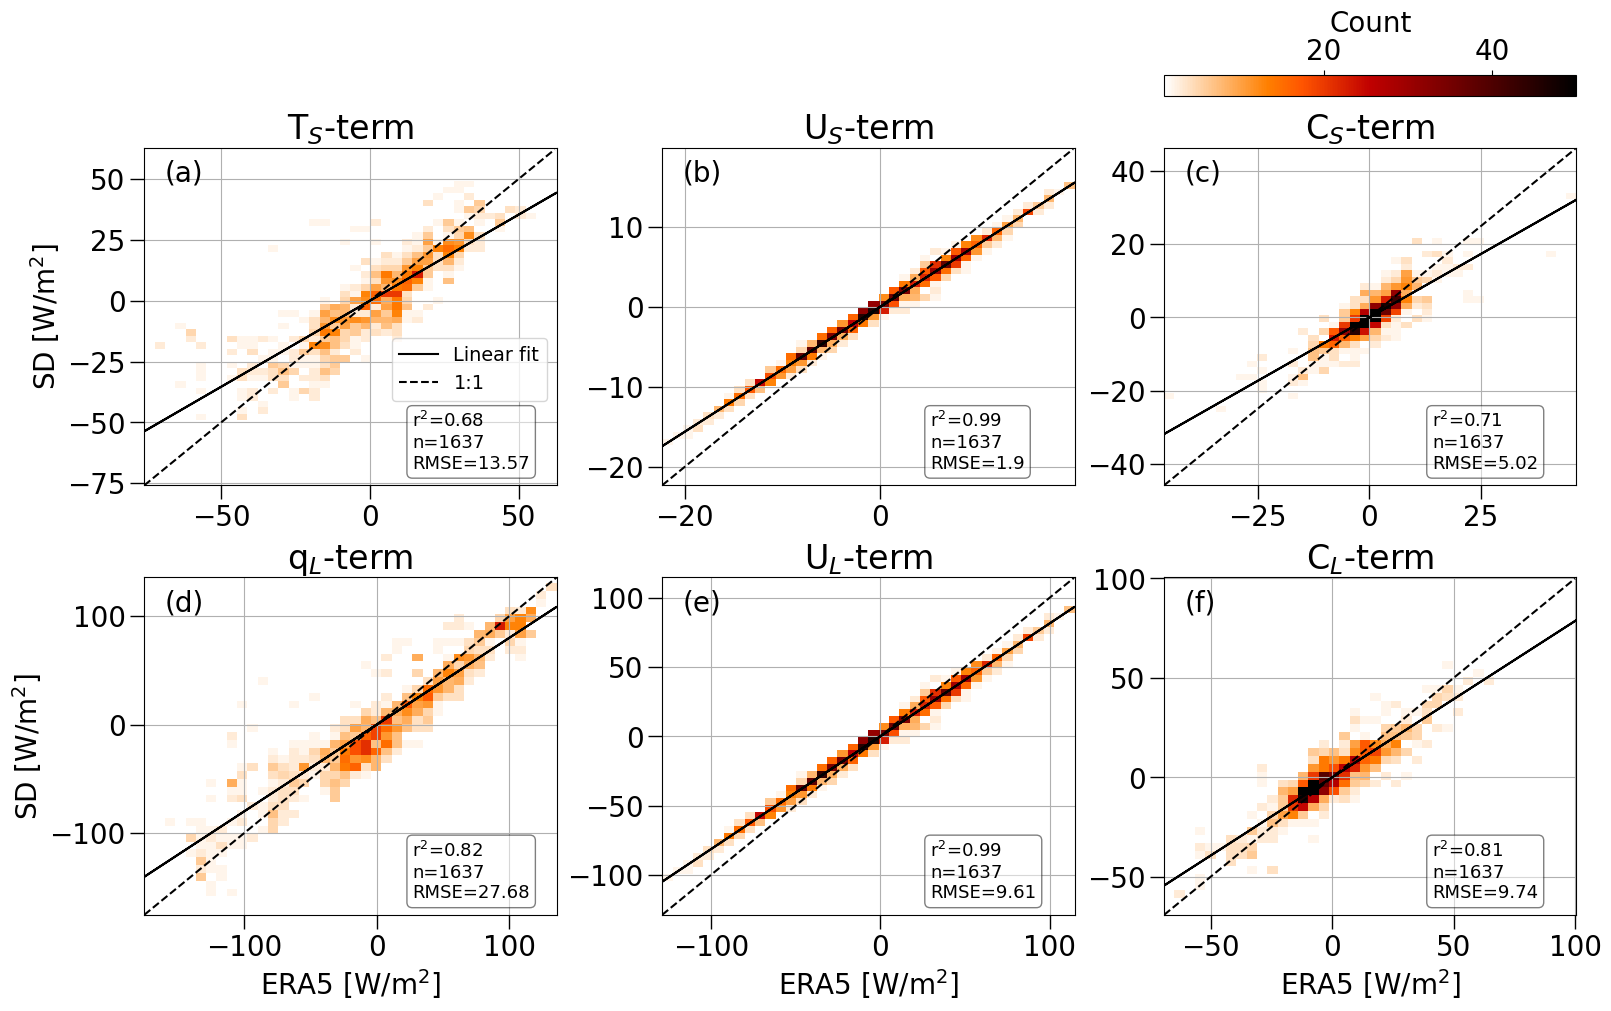

In [69]:

fig, ax=plt.subplots(2,3, figsize=[16,10], constrained_layout=True)

s_terms=['t_term', 'u_term_t', 'cov_term_t']
l_terms=['q_term', 'u_term_q', 'cov_term_q']

labelS = ['T$_S$-term', 'U$_S$-term', 'C$_S$-term']
labelL = ['q$_L$-term', 'U$_L$-term', 'C$_L$-term']

fig_label=[['(a)','(b)','(c)'],['(d)','(e)','(f)']]

bbox = dict(boxstyle="square", fc="0.8")

ticksize=14

text_x=0.05
text_y=0.9

for i in np.arange(3):
    msk=np.isfinite(ERA5_skin_rec[s_terms[i]])
    msk1=np.isfinite(SD_rec[s_terms[i]])
    
    x= ERA5_skin_rec.shf_coeffs*ERA5_skin_rec[s_terms[i]].sel(index=(msk & msk1))
    y= SD_rec.shf_coeffs*SD_rec[s_terms[i]].sel(index= (msk & msk1))

    
    wind1=ax[0,i].hist2d(x, y, bins=40, cmin=1,cmap='gist_heat_r', vmax=50)
    #ax[0,i].scatter(x, y) #Idea is to color by wind, then we can see if there is issues at high or low windspeeds

    
#    cax = ax[0,i].inset_axes([0.2, 0.9, 0.3, 0.05])
#    cbar=fig.colorbar(wind1[3], cax=cax, label=('Count'), orientation='horizontal')
    #Create linear fit line and plot
    cbar.ax.tick_params(labelsize=ticksize)
    cbar.set_label(label='Count', size=ticksize)
#cax = ax[0,i].inset_axes([0.3, 0.07, 0.4, 0.04])
#fig.colorbar(pcm, cax=cax, orientation='horizontal')

    ax[0,i].set_xlim(x.min(), x.max())
    ax[0,i].set_ylim(x.min(), x.max())

    ax[0,i].annotate(fig_label[0][i], xy=(text_x, text_y), xycoords='axes fraction')#, bbox=bbox)
  #####################################################  
    #obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(x, y, 1)
    
    #add linear regression line to scatterplot 
    ax[0,i].plot(x, m*x+b, color='k', label='Linear fit')
    ax[0,i].plot(np.arange(x.min(), x.max(), 1), np.arange(x.min(), x.max(), 1) , linestyle='--', color='k', label=('1:1'))
    #Create stats and statbox
    RMSE = math.sqrt(mean_squared_error(x, y))
    
    r2=scipy.stats.linregress(x, y).rvalue**2
    n = len(x)
    #p= scipy.stats.linregress(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))).pvalue
    
    textstr= 'r$^2$='+ str(round(r2, 2)) + '\n'+ 'n=' +str(n) + '\n' + 'RMSE='+ str(round(RMSE,2)) 
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax[0,i].annotate(textstr, xy=(0.65, 0.22), xycoords='axes fraction', bbox=props, va='top',fontsize=13)

    msk=np.isfinite(SD_rec[l_terms[i]])
    msk1=np.isfinite(ERA5_skin_rec[l_terms[i]])
    
    x= ERA5_skin_rec.lhf_coeffs*ERA5_skin_rec[l_terms[i]].sel(index=(msk& msk1))
    y= SD_rec.lhf_coeffs*SD_rec[l_terms[i]].sel(index=(msk& msk1))
    
    
    #ax[1,i].scatter(x, y)
    wind2= ax[1,i].hist2d(x, y, bins=40, cmin=1, label=labelL[i],cmap='gist_heat_r', vmax=50)
    #cbar.ax.tick_params(labelsize=ticksize)
    
    #cbar.set_label(label='Count', size=ticksize)
    #cbar.set_fontsize(20)
    
    m, b = np.polyfit(x, y, 1)
    
    #add linear regression line to scatterplot 
    ax[1,i].plot(x, m*x+b, color='k', label='Linear fit')
    ax[1,i].plot(np.arange(x.min(), x.max(), 1), np.arange(x.min(), x.max(), 1) , linestyle='--', color='k', label=('1:1'))
    #Create stats and statbox
    RMSE = math.sqrt(mean_squared_error(x, y))
    
    r2=scipy.stats.linregress(x, y).rvalue**2
    n = len(x)
    #p= scipy.stats.linregress(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))).pvalue
    
    textstr='r$^2$='+ str(round(r2, 2)) + '\n'+ 'n=' +str(n) + '\n' + 'RMSE='+ str(round(RMSE,2)) 
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    


    ax[1,i].annotate(textstr, xy=(0.65, 0.22), xycoords='axes fraction', bbox=props, va='top',fontsize=13)
    ax[1,i].annotate(fig_label[1][i], xy=(text_x, text_y), xycoords='axes fraction')#, bbox=bbox)
#    ax[0,i].set_title('Q$_S´$')
#    ax[1,i].set_title('Q$_L´$')
    
    ax[0,i].set_title(labelS[i])    
    ax[1,i].set_title(labelL[i])

    
    ax[0,i].grid()
    ax[1,i].grid()
    
    
#    ax[1,i].legend(loc='lower right', fontsize='x-small')

    ax[1,i].set_xlim(x.min(), x.max())
    ax[1,i].set_ylim(x.min(), x.max())
#    mask = ~np.isnan(varprime.Qs) & ~np.isnan(varprime.deltaT)

#    scipy.stats.linregress(varprime.Qs[mask], varprime.deltaT[mask])

#cax = ax[0,0].inset_axes([0.2, 0.9, 0.3, 0.05])
    
cbar=fig.colorbar(wind2[3], ax=ax[0,2], label=('Count'), orientation='horizontal', location='top')
ax[0,0].legend(loc=(0.6,0.25), fontsize='x-small')

ax[0,0].set_ylabel('SD [W/m$^2$]')
ax[1,0].set_ylabel('SD [W/m$^2$]')

ax[1,0].set_xlabel('ERA5 [W/m$^2$]')
ax[1,1].set_xlabel('ERA5 [W/m$^2$]')
ax[1,2].set_xlabel('ERA5 [W/m$^2$]')

ax[1,0].tick_params(axis='both', which='major', width=1, length=10)
ax[1,1].tick_params(axis='both', which='major', width=1, length=10)
ax[1,2].tick_params(axis='both', which='major', width=1, length=10)

ax[0,0].tick_params(axis='both', which='major', width=1, length=10)
ax[0,1].tick_params(axis='both', which='major', width=1, length=10)
ax[0,2].tick_params(axis='both', which='major', width=1, length=10)

    
plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/final_figs/ERA5-SD-terms.png')

### Upscale cov terms, upscale cov r2 plots
### upscale wind variability?

In [60]:
rec_ds_qTU=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleERA5_qTU.nc')

In [61]:
rec_ds_qTU

<xarray.Dataset>
Dimensions:         (longitude: 121, latitude: 65, time: 1638)
Coordinates:
  * longitude       (longitude) float32 0.0 0.25 0.5 0.75 ... 29.5 29.75 30.0
  * latitude        (latitude) float32 -30.0 -30.25 -30.5 ... -45.5 -45.75 -46.0
  * time            (time) datetime64[ns] 2022-09-15T18:00:00 ... 2022-11-22T...
Data variables: (12/17)
    t_term          (time, latitude, longitude) float64 ...
    u_term_t        (time, latitude, longitude) float64 ...
    q_term          (time, latitude, longitude) float64 ...
    u_term_q        (time, latitude, longitude) float64 ...
    lhf_coeffs      (time, latitude, longitude) float64 ...
    shf_coeffs      (time, latitude, longitude) float64 ...
    ...              ...
    shf_mean        (time, latitude, longitude) float64 ...
    lhf_recomposed  (time, latitude, longitude) float64 ...
    shf_recomposed  (time, latitude, longitude) float64 ...
    q_bar           (time, latitude, longitude) float64 ...
    T_bar           (time, latitude, longitude) float64 ...
    U_bar           (time, latitude, longitude) float64 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-09 13:22:35 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

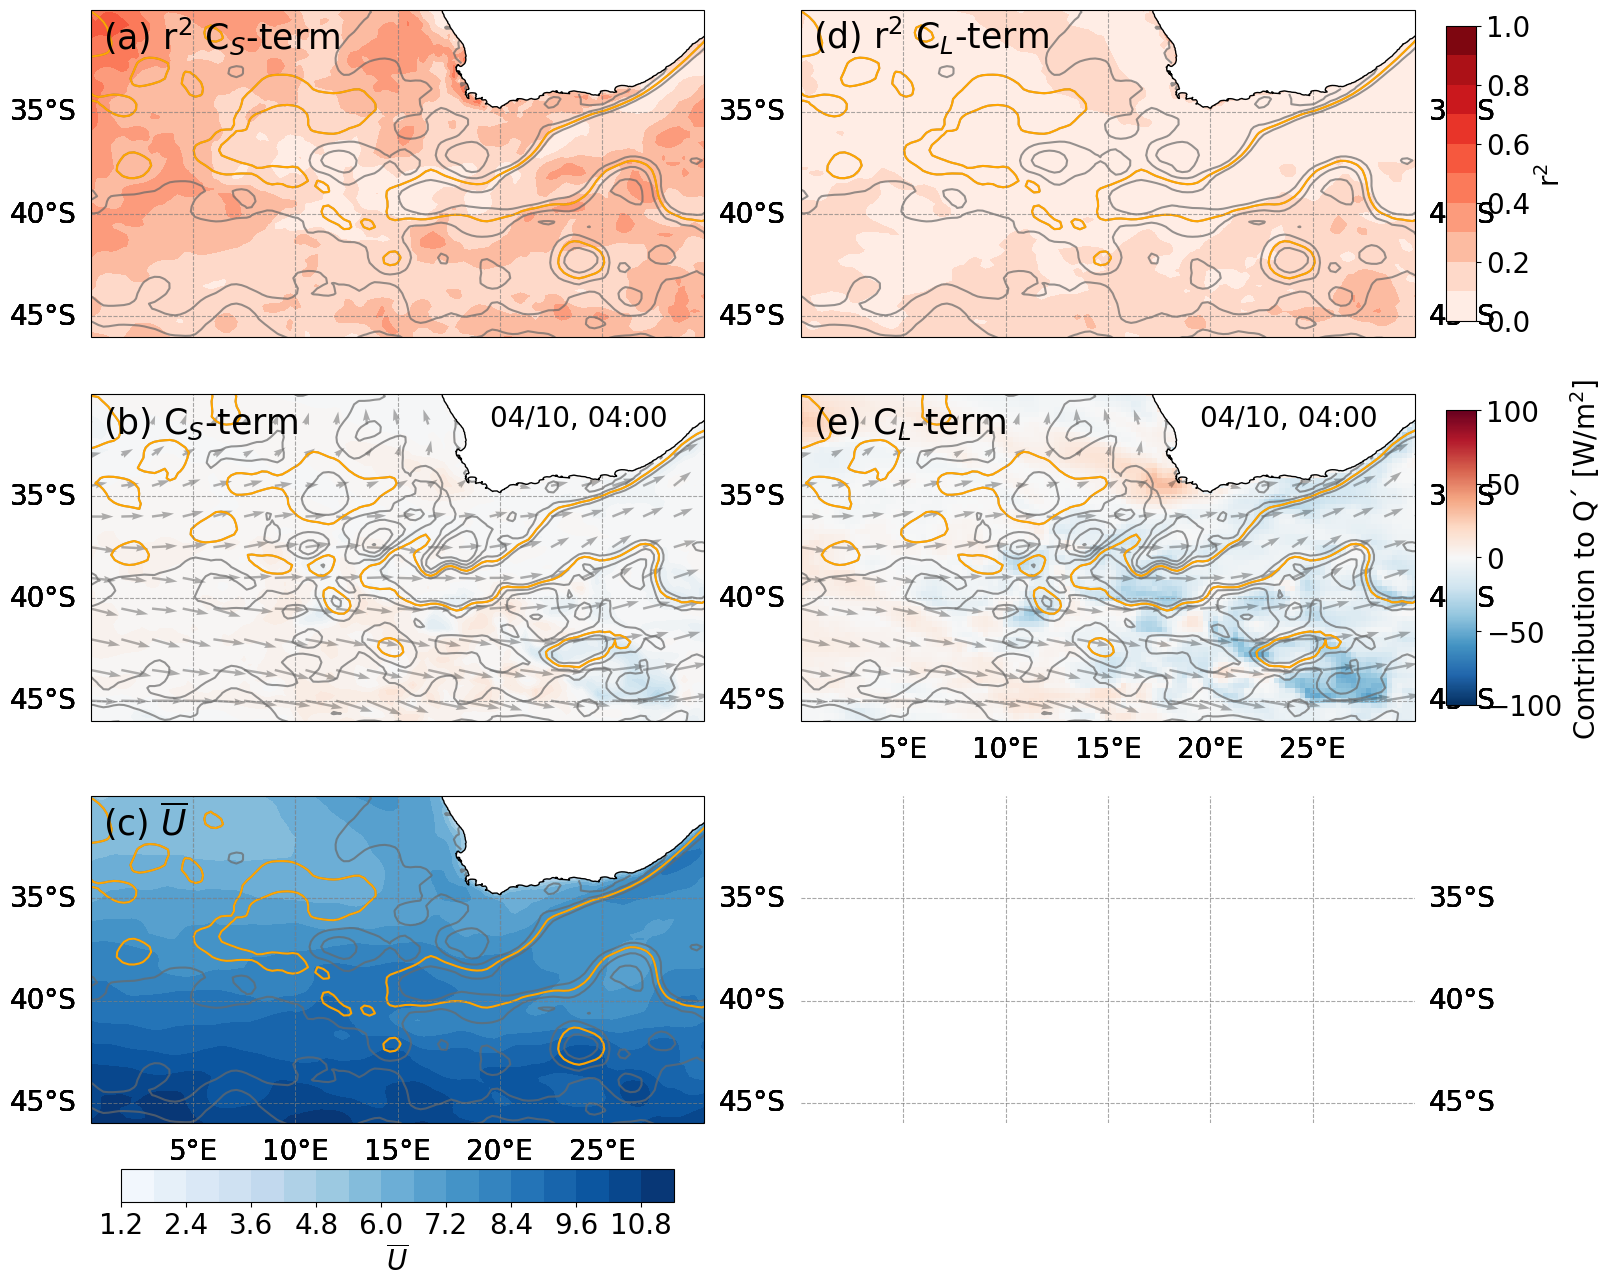

In [63]:

from matplotlib.colors import TwoSlopeNorm
#time=100
vmin_l=0
vmax_l=1

vmin_s=vmin_l
vmax_s=vmax_l
cmap='Reds'
cmap2='Greys'

cmapT='RdBu_r'
cmapq='Blues'
levels=np.arange(0, 1.1, 0.1)
levels2=10

vmin_T=-100#-4
vmax_T=100#1.4
levels_T=15

vmin_q=None#-0.05
vmax_q=None#0.05
levels_q=10

adt_levels=np.arange(-1.8, 1, 0.2)

rec_ds=rec_r2#rec_ds_ERA5#rec_r2_out_1#rec_r2
bbox = dict(boxstyle="square", fc='w')

fig, ax=plt.subplots(3,2, figsize=[16,13], constrained_layout=True, sharey=True, sharex=True,subplot_kw={'projection':ccrs.PlateCarree()})

#ax[0,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.shf_fluc)#, vmin=vmin_s, vmax=vmax_s, cmap=cmap )

ax[0,0].contourf(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_t, vmin=vmin_s, vmax=vmax_s, cmap=cmap, levels=levels )
cbar_l=ax[0,1].contourf(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_q, vmin=vmin_s, vmax=vmax_s, cmap=cmap , levels=levels)

ax[1,0].contourf(ERA5big.longitude, ERA5big.latitude, rec_ds_qTU.isel(time=442).cov_term_t,levels=levels_T, cmap=cmapT, vmin=vmin_T, vmax=vmax_T)
#cbar_cov=ax[1,1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds_qTU.isel(time=442).u_term_q , cmap=cmapT, vmin=vmin_T, vmax=vmax_T)
cbar_cov=ax[1,1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds_qTU.isel(time=442).cov_term_q, cmap=cmapT, vmin=vmin_T, vmax=vmax_T)

ERA5time=ERA5big.isel(time=442)
longitudes=ERA5time.longitude[0::6].values
latitudes=ERA5time.latitude[0::6].values

ERA5time=ERA5time.sel(longitude=longitudes, latitude=latitudes)

ax[1,0].quiver(ERA5time.longitude, ERA5time.latitude, ERA5time.u10, ERA5time.v10, alpha=0.3)#, ERA5time.rh)#np.sqrt((ERA5time.u10**2+ERA5time.v10**2)))
ax[1,1].quiver(ERA5time.longitude, ERA5time.latitude, ERA5time.u10, ERA5time.v10, alpha=0.3)#, ERA5time.rh)#np.sqrt((ERA5time.u10**2+ERA5time.v10**2)))


#norm = TwoSlopeNorm(vmin=rec_ds_qTU.isel(time=5).U_bar.min().values, vcenter=0, vmax=rec_ds_qTU.isel(time=5).U_bar.max().values )
U_cbar=ax[2,0].contourf(ERA5big.longitude, ERA5big.latitude, rec_ds_qTU.isel(time=5).U_bar,levels=levels_T, cmap=cmapq)#, vmin=vmin_T, vmax=vmax_T)#, norm=norm )

#plt.colorbar(cbar_s, ax=ax[0,2+1], label='Contribution to Q$^\prime _{S}$ [W/m$^2$] ')


#ax[1,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.lhf_fluc)#, vmin=vmin_l, vmax=vmax_l, cmap=cmap )
#ax[0,1].contourf(ERA5big.longitude, ERA5big.latitude, rec_ds.q_term, vmin=vmin_l, vmax=vmax_l, cmap=cmap, levels=levels )
#cbar_l=ax[1,1].contourf(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_q, vmin=vmin_l, vmax=vmax_l, cmap=cmap, levels=levels )

#norm = TwoSlopeNorm(vmin=rec_ds_qTU.isel(time=5).q_bar.min().values, vcenter=0, vmax=0.1 )
#q_cbar=ax[2,1].contourf(ERA5big.longitude, ERA5big.latitude, rec_ds_qTU.isel(time=5).U_bar, levels=levels_q, cmap=cmapq, vmin=vmin_q, vmax=vmax_q, norm=norm )


ax[0,0].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), colors='dimgray', levels=adt_levels, alpha=0.7)
ax[1,0].contour(SSH.longitude,SSH.latitude, SSH.isel(time=33).adt, colors='dimgray', levels=adt_levels, alpha=0.7)
ax[2,0].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), colors='dimgray', levels=adt_levels, alpha=0.7)

ax[0,1].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), colors='dimgray', levels=adt_levels, alpha=0.7)
ax[1,1].contour(SSH.longitude,SSH.latitude, SSH.isel(time=33).adt, colors='dimgray', levels=adt_levels, alpha=0.7)
#ax[2,1].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), colors='dimgray', levels=adt_levels, alpha=0.7)


ax[0,0].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), colors='orange', levels=[0.6])
ax[1,0].contour(SSH.longitude,SSH.latitude, SSH.isel(time=33).adt, colors='orange', levels=[0.6])
ax[2,0].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), colors='orange', levels=[0.6])

ax[0,1].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), colors='orange', levels=[0.6])
ax[1,1].contour(SSH.longitude,SSH.latitude, SSH.isel(time=33).adt, colors='orange', levels=[0.6])
#ax[2,1].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), colors='orange', levels=[0.6])

#ax[1,0].contour(ERA5big.longitude, ERA5big.latitude, rec_ds.q_term, vmin=vmin_l, vmax=vmax_l, cmap=cmap2, levels=levels2 )
#ax[1,1].contour(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_q, vmin=vmin_l, vmax=vmax_l, cmap=cmap2, levels=levels2 )
#ax[1,2].contour(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_q, vmin=vmin_l, vmax=vmax_l, cmap=cmap2, levels=levels2 )


#plt.colorbar(cbar_l, ax=ax[1,3], label='Contribution to Q$^\prime$ [W/m$^2$] ', orientation='horizontal')


#ax[1,2].set_title('C$_L$-term')
alpha=0.4

#ax[0,0].grid(alpha=alpha)
ax[0,0].grid(alpha=alpha)
ax[1,0].grid(alpha=alpha)
#ax[2,0].grid(alpha=alpha)

#ax[1,0].grid(alpha=alpha)
ax[0,1].grid(alpha=alpha)
ax[1,1].grid(alpha=alpha)
#ax[2,1].grid(alpha=alpha)

    
ToF_bottom1=[False, False, True, True]
ToF_left1=[True, True, True, True]

ToF_bottom=[False, True, False, True]
ToF_left=[False, False, False, False]

# Add land and coastline
for i in np.arange(3):    
    ax[i,0].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)
    ax[i,1].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)

#    ax[0,i].scatter(dsadcpH.longitude[:time], dsadcpH.latitude[:time], s=30, color='grey', alpha=0.2,label='SD 1067 path')
#    ax[0,i].scatter(dsadcpH.longitude[time], dsadcpH.latitude[time], s=50, color='darkorange', marker='^', alpha=0.8, edgecolor='k',label='SD 1067')
    

#    ax[1,i].scatter(dsadcpH.longitude[:time], dsadcpH.latitude[:time], s=30, color='grey', alpha=0.2,label='SD 1067 path')
#    ax[1,i].scatter(dsadcpH.longitude[time], dsadcpH.latitude[time], s=50, color='darkorange', marker='^', alpha=0.8, edgecolor='k',label='SD 1067')


    
    for k,spine in ax[i,0].spines.items():  #ax.spines is a dictionary
            spine.set_zorder(12)
            gridlines(ax[i,0],5,5, ToF_bottom1[i], ToF_left1[i])
    
    for k,spine in ax[i,1].spines.items():  #ax.spines is a dictionary
            spine.set_zorder(12)
            gridlines(ax[i,1],5,5, ToF_bottom[i], ToF_left[i])

plt.xlim(ERA5big.longitude.min(), ERA5big.longitude.max())
plt.ylim(ERA5big.latitude.min(), ERA5big.latitude.max())


ax[1,1].annotate((pd.to_datetime(rec_ds_qTU.time.values[442]).strftime("%d/%m, %H:%M")), xy=(0.65, 0.9), xycoords='axes fraction',fontsize=20)#, bbox=bbox)
ax[1,0].annotate((pd.to_datetime(rec_ds_qTU.time.values[442]).strftime("%d/%m, %H:%M")), xy=(0.65, 0.9), xycoords='axes fraction',fontsize=20)#, bbox=bbox)


x=0.02
y=0.9
#ax[0,0].set_title('Q$^\prime$$_S$')
#ax[0,0].annotate('(a) T$_S$-term',xy=(x,y), xycoords='axes fraction', fontsize=labelfont)
#ax[1,0].annotate('(b) U$_S$-term',xy=(x,y), xycoords='axes fraction', fontsize=labelfont)
#ax[2,0].annotate('(c) $\overline{U}$',xy=(x,y), xycoords='axes fraction', fontsize=labelfont)

#ax[0,1].annotate('(d) q$_L$-term',xy=(x,y), xycoords='axes fraction', fontsize=labelfont)
#ax[1,1].annotate('(e) U$_L$-term',xy=(x,y), xycoords='axes fraction', fontsize=labelfont)
#ax[2,1].annotate('(f) $\overline{\Delta q}$',xy=(x,y), xycoords='axes fraction', fontsize=labelfont)

#cbar.ax.tick_params(labelsize=20)

vaxis=[1.05, 0.05, 0.05, 0.9]

cax = ax[0,1].inset_axes(vaxis)
cbar=fig.colorbar(cbar_l, cax=cax, label=('r$^2$ '), orientation='vertical')#, location='top')

cax = ax[1,1].inset_axes(vaxis)
cbar=fig.colorbar(cbar_cov, cax=cax, label=('Contribution to Q´ [W/m$^2$] '), orientation='vertical')#, location='bottom')

cax = ax[2,0].inset_axes([0.05, -0.24, 0.9, 0.1])
cbar=fig.colorbar(U_cbar, cax=cax, label=('$\overline{U}$ '), orientation='horizontal', location='bottom')

labelfont=25
x=0.02
y=0.88

ax[0,0].annotate('(a) r$^2$ C$_S$-term',xy=(x,y), xycoords='axes fraction', fontsize=labelfont)
ax[1,0].annotate('(b) C$_S$-term',xy=(x,y), xycoords='axes fraction', fontsize=labelfont)
ax[2,0].annotate('(c) $\overline{U}$',xy=(x,y), xycoords='axes fraction', fontsize=labelfont)

ax[0,1].annotate('(d) r$^2$ C$_L$-term',xy=(x,y), xycoords='axes fraction', fontsize=labelfont)
ax[1,1].annotate('(e) C$_L$-term',xy=(x,y), xycoords='axes fraction', fontsize=labelfont)
#ax[2,1].annotate('(f) $\overline{\Delta q}$',xy=(x,y), xycoords='axes fraction', fontsize=labelfont)

ax[2, 1].cla()
ax[2, 1].axis("off")


plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/final_figs/appendix_upscale.png', bbox_inches='tight')
#ax[1,1].legend(bbox_to_anchor=[0.99,-0.12])

## Current speed

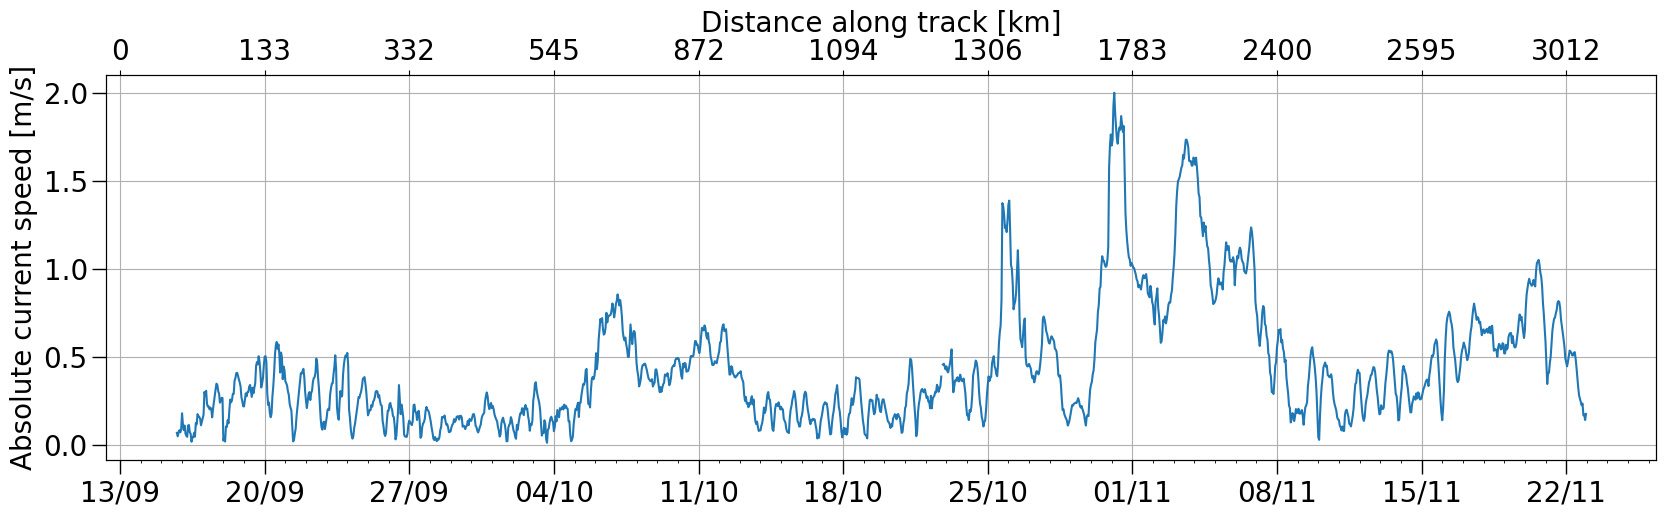

In [64]:
fig, ax = plt.subplots(figsize=[20,5])
plt.plot(dsadcpH.time, dsadcpH.abs_cur)

ax2=ax.twiny()
ax2.plot(dsadcpH.time, dsadcpH.abs_cur, label='SD 1067', color='darkorange', alpha=0)
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
xticks_timeunits = ax2.get_xticks()

#xticks_timeunits = np.linspace(mdates.date2num(np.min(dsadcpH.time.values)) , mdates.date2num(np.max(dsadcpH.time.values)) , 10)

def lookup_table(ticktime):
    index_of_nearest_time = np.argmin(np.abs(mdates.date2num(dsadcpH.time)-ticktime))
    return dist_along_track[index_of_nearest_time]
    
xticks_distanceunits = xticks_timeunits * np.NaN 
for idx, val in enumerate(xticks_timeunits):
    xticks_distanceunits[idx] = int(lookup_table(xticks_timeunits[idx]))
    
ticks=[]
for i in np.arange(len(xticks_timeunits)):
    ticks.append(int(xticks_distanceunits[i]))

xticks_distanceunits=np.array(ticks)


ax2.set_xticks(xticks_timeunits)
ax2.set_xticklabels(xticks_distanceunits)

ax.tick_params(axis='both', which='major', width=1, length=10)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
myFmt = mdates.DateFormatter('%d'+'/'+'%m')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax2.set_xlabel('Distance along track [km]')

ax.set_ylabel('Absolute current speed [m/s]')

ax.grid()

plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/final_figs/current_speed.png')

Rel windspeed vs not

In [63]:
hum1=dsadcpH.rh.values

spd= coloc3.abs_rel.values#relative windpeed
SST= dsadcpH.sst.values
T= dsadcpH.t2m.values #seasurface temperature in kelvin. Will convert iff less than 200
hum= ['rh', hum1 ] #chose rh, spec hum or dew point temp.
P= dsadcpH.P_SEA.values #air pressure in hPA
SST_fl ='bulk' #string, 'bulk' or 'skin' for input
meth= 'C35' #string, choose method of calcultion
lat= dsadcpH.latitude.values #latitude
hin=([10, 2.3, 2.3])  #sensor heights in m, 3x1 same order as output 
hout=10 #output height, default is 10m
Rl=dsadcpH.dwlw.values#longwave dwn radiation
Rs= dsadcpH.dwsw.values # shortwave dwn radiation
cskin= 1 #0 cool skin adj off
skin='C35' #'C35' #string "C35", "ecmwf" or "Beljaars"
wl=0 #warm layer off 0 (default)
gust= None# [x,beta,zi,ustbj] #Check documentation
qmeth= 'Buck2' #string, saturation evaporation method
tol= None #float, tolerance limits for fluxes and heights, check documentation
maxiter= 30 #number fo iterations
out= 0 #int, set 0 to set points thathave not converged
out_var= None #str, define pandas arrayod variables for output. There i a default for cskin and gust off. Check documentation
L=None #str, M-O definition option. 'tsrv' is default

ASFC=AirSeaFluxCode(spd, T, SST, SST_fl, meth, lat=lat, hum=hum, P=P,
                   hin=hin, hout=hout, Rl=Rl, Rs=Rs, cskin=cskin, skin=skin, wl=wl,
                   gust=gust, qmeth=qmeth, tol=tol, maxiter=maxiter, out=out,
                   out_var=out_var, L=L)

rel_QL=ASFC.latent
rel_QS=ASFC.sensible

hum1=dsadcpH.rh.values

spd= coloc3.WIND_CORR10.values#relative windpeed
SST= dsadcpH.sst.values
T= dsadcpH.t2m.values #seasurface temperature in kelvin. Will convert iff less than 200
hum= ['rh', hum1 ] #chose rh, spec hum or dew point temp.
P= dsadcpH.P_SEA.values #air pressure in hPA
SST_fl ='bulk' #string, 'bulk' or 'skin' for input
meth= 'C35' #string, choose method of calcultion
lat= dsadcpH.latitude.values #latitude
hin=([10, 2.3, 2.3])  #sensor heights in m, 3x1 same order as output 
hout=10 #output height, default is 10m
Rl=dsadcpH.dwlw.values#longwave dwn radiation
Rs= dsadcpH.dwsw.values # shortwave dwn radiation
cskin= 1 #0 cool skin adj off
skin='C35' #'C35' #string "C35", "ecmwf" or "Beljaars"
wl=0 #warm layer off 0 (default)
gust= None# [x,beta,zi,ustbj] #Check documentation
qmeth= 'Buck2' #string, saturation evaporation method
tol= None #float, tolerance limits for fluxes and heights, check documentation
maxiter= 30 #number fo iterations
out= 0 #int, set 0 to set points thathave not converged
out_var= None #str, define pandas arrayod variables for output. There i a default for cskin and gust off. Check documentation
L=None #str, M-O definition option. 'tsrv' is default

ASFC=AirSeaFluxCode(spd, T, SST, SST_fl, meth, lat=lat, hum=hum, P=P,
                   hin=hin, hout=hout, Rl=Rl, Rs=Rs, cskin=cskin, skin=skin, wl=wl,
                   gust=gust, qmeth=qmeth, tol=tol, maxiter=maxiter, out=out,
                   out_var=out_var, L=L)


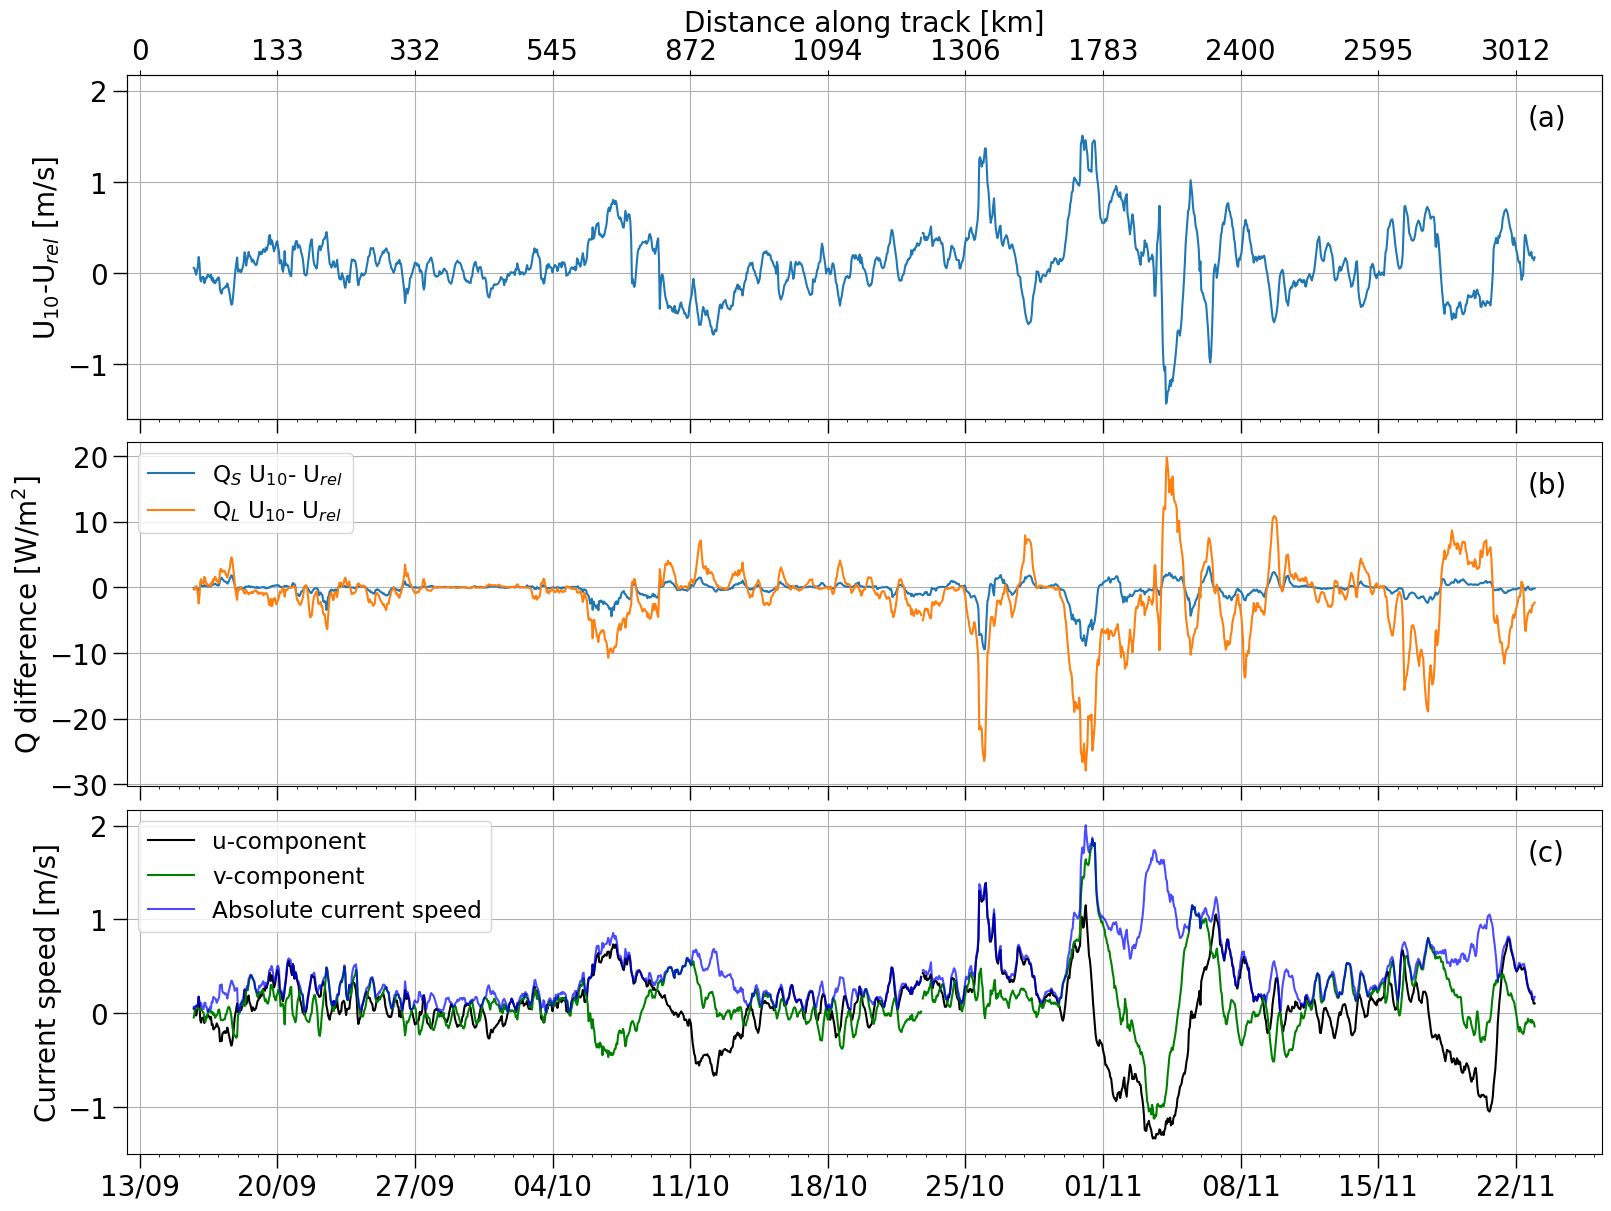

In [64]:
figno=3

fig, ax=plt.subplots(figno,1, figsize=[16,12], sharex=True, constrained_layout=True)

ax[0].plot(dsadcpH.time, coloc3.WIND_CORR10-coloc3.abs_rel)


ax[1].plot(dsadcpH.time, ASFC.sensible-rel_QS, label='Q$_S$ U$_{10}$- U$_{rel}$')


ax[1].plot(dsadcpH.time, ASFC.latent-rel_QL, label='Q$_L$ U$_{10}$- U$_{rel}$')


ax[2].plot(dsadcpH.time, dsadcpH.cur_u, label='u-component', c='k')
ax[2].plot(dsadcpH.time, dsadcpH.cur_v, label='v-component', c='green')
ax[2].plot(dsadcpH.time, dsadcpH.abs_cur, label='Absolute current speed', c='blue', alpha=0.7)


ax[0].set_ylabel('U$_{10}$-U$_{rel}$ [m/s]')
ax[1].set_ylabel('Q difference [W/m$^2$]')

#ax[2].set_ylabel('Q$_L$ [W/m$^2$]')
ax[2].set_ylabel('Current speed [m/s]')

for i in np.arange(figno):
    ax[i].grid()

ax[1].legend(loc='upper left', fontsize='small')
ax[2].legend(loc='upper left', fontsize='small')




ax2=ax[0].twiny()
ax2.plot(dsadcpH.time, dsadcpH.abs_cur, label='SD 1067', color='darkorange', alpha=0)
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
xticks_timeunits = ax2.get_xticks()

#xticks_timeunits = np.linspace(mdates.date2num(np.min(dsadcpH.time.values)) , mdates.date2num(np.max(dsadcpH.time.values)) , 10)

def lookup_table(ticktime):
    index_of_nearest_time = np.argmin(np.abs(mdates.date2num(dsadcpH.time)-ticktime))
    return dist_along_track[index_of_nearest_time]
    
xticks_distanceunits = xticks_timeunits * np.NaN 
for idx, val in enumerate(xticks_timeunits):
    xticks_distanceunits[idx] = int(lookup_table(xticks_timeunits[idx]))
    
ticks=[]
for i in np.arange(len(xticks_timeunits)):
    ticks.append(int(xticks_distanceunits[i]))

xticks_distanceunits=np.array(ticks)


ax2.set_xticks(xticks_timeunits)
ax2.set_xticklabels(xticks_distanceunits)

ax[0].tick_params(axis='both', which='major', width=1, length=10)
ax[1].tick_params(axis='both', which='major', width=1, length=10)
ax[2].tick_params(axis='both', which='major', width=1, length=10)

ax[0].xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
myFmt = mdates.DateFormatter('%d'+'/'+'%m')
ax[0].xaxis.set_major_formatter(myFmt)
ax[0].xaxis.set_minor_locator(mdates.DayLocator())
ax2.set_xlabel('Distance along track [km]')

x=0.95
y=0.85
ax[0].annotate('(a)', xy=(x,y), xycoords='axes fraction')
ax[1].annotate('(b)', xy=(x,y), xycoords='axes fraction')
ax[2].annotate('(c)', xy=(x,y), xycoords='axes fraction')


plt.savefig(pathlib.Path('.').absolute().parent/'MTmichaela/final_figs/relwindvsnotdiff.png')

In [65]:
print((ASFC.sensible-rel_QS).max())
print((ASFC.sensible-rel_QS).min())

print((ASFC.latent-rel_QL).max())

print((ASFC.latent-rel_QL).min())

3.1674572375434025
-9.469909867875622
19.789125192378457
-27.93372662017643
